In [ ]:
!pip install mpltools

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.5/101.5 kB 2.5 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for mpltools: filename=mpltools-0.2.0-py3-none-any.whl size=35680 sha256=24868985293bc50268edc8ed0efad7c8429819b3b0b444ae7cfeab819530667d
  Stored in directory: /root/.cache/pip/wheels/da/f9/f8/62ee15317bd486aa16e2dd4dc3713e35dec12d384a45665f0f
  Created wheel for configobj: filename=configobj-5.0.9-py2.py3-none-any.whl size=35614 sha256=6d69d9d3ee701e66a4ce06d969bdb902840c2218562e7bd6c63c9642beb6cb0e
  Stored in directory: /root/.cache/pip/wheels/a1/6c/03/6c5e3cf1a6e4b9e2fc5c4409be4abc5a8268bd9c878739cb32
Successfully built mpltools configobj


In [ ]:
import pylab as plt
import numpy as np
import tifffile
import pandas as pd
from os import listdir
from PIL import ImageOps
from PIL import Image as PImage
import os
import matplotlib.pyplot as plt
from tqdm import tqdm
from math import cos, radians, sqrt
import numpy as np
import pandas as pd
from mpltools import annotation
# import dotenv
import cv2
import math
import numpy as np

import PIL
from PIL import Image
Image.MAX_IMAGE_PIXELS = None
import numba
import glob

# Analysis the detection results

### Extract the dataset

In [ ]:
def find_xywh(pathtxt,list_txt,size):
    imgsize = [size,size]
    # imgs = loadImages(pathimg)
    # img = imgs[0]
    len_imgs = len(list_txt)
    counterall = 0
    countersmall = 0
    countermedium = 0
    counterlarge = 0
    c = 0
    df = pd.DataFrame(None, columns = ['size'])
    x = []
    y = []
    w = []
    h = []
    for i in tqdm(range(len_imgs)):


        listtxt = list_txt[i]
        file_name = listtxt.split('.txt')[0]

        base_x = int(file_name.split('_')[-6])
        base_y = int(file_name.split('_')[-5])
#         print(file_name)
#         print(file_name.split('_')[-6])
#         print(file_name.split('_')[-5])
        gapx = base_x
        gapy = base_y
#         print(f"gapx: {gapx}, gapy: {gapy}")
        if os.path.exists(pathtxt+listtxt):

            array = np.loadtxt(pathtxt+listtxt,dtype=float)
            n = 6
            l = len(array)
            txt = []
            if array.size == n:
                x.append(array[1]*imgsize[1]+gapx-array[3]*imgsize[1]/2)
                y.append(array[2]*imgsize[0]+gapy-array[4]*imgsize[0]/2)
                w.append(array[3]*imgsize[1])
                h.append(array[4]*imgsize[0])
            else:
                for i in range(l):
                    for j in range(4):
                        if j == 0 or j == 2:
                            txt.append(array[i][j+1]*imgsize[1])
                        elif j == 1 or j == 3:
                            txt.append(array[i][j+1]*imgsize[0])
                txt = np.reshape(txt, (l,4))
                for i in range(l):
                    x.append(txt[i][0]+gapx-txt[i][2]/2)
                    y.append(txt[i][1]+gapy-txt[i][3]/2)
                    w.append(txt[i][2])
                    h.append(txt[i][3])
        else:
            pass

    return x,y,w,h

### Remove the overlapping craters

In [ ]:
import pandas as pd

class UnionFind:
    def __init__(self, size):
        self.parent = list(range(size))

    def find(self, i):
        if self.parent[i] != i:
            self.parent[i] = self.find(self.parent[i])  # Path compression
        return self.parent[i]

    def union(self, i, j):
        pi, pj = self.find(i), self.find(j)
        if pi != pj:
            self.parent[pi] = pj  # Union


def compute_iou_vectorized(coords1, coords2):
    # Extract coordinates
    x1, y1, w1, h1 = coords1
    x2, y2, w2, h2 = coords2

    # Calculate the coordinates of the intersection rectangle
    x_left = max(x1, x2)
    y_top = max(y1, y2)
    x_right = min(x1 + w1, x2 + w2)
    y_bottom = min(y1 + h1, y2 + h2)

    # Check if there is an intersection
    if x_right < x_left or y_bottom < y_top:
        return 0.0  # No intersection

    # Calculate areas
    intersection_area = (x_right - x_left) * (y_bottom - y_top)
    area1 = w1 * h1
    area2 = w2 * h2

    # Calculate Union area
    union_area = area1 + area2 - intersection_area

    # Compute IOU
    iou = intersection_area / union_area
    return iou

def is_max_edge_ratio_similar_vectorized(coords1, coords2, thres):
    # Extract coordinates
    x1, y1, w1, h1 = coords1
    x2, y2, w2, h2 = coords2

    small_w = min(w1, w2)
    large_w = max(w1, w2)
    small_h = min(h1, h2)
    large_h = max(h1, h2)

    ratio_w = small_w / large_w
    ratio_h = small_h / large_h
    # if the max edge lengths of two bounding boxes are similar, one of them is a redundant detection to remove
    if ratio_w > thres or ratio_h > thres:
      return True
    return False


@numba.jit(nopython=True)
def _remove_overlap_union(df1, uf):
  # Group elements based on IOU and edge ratio similarity
  for i in range(len(df1)):
      for j in range(i + 1, len(df1)):
          if compute_iou_vectorized(df1[i], df1[j]) > iou_thres and is_max_edge_ratio_similar_vectorized(df1[i], df1[j],size_thres):
              uf.union(i, j)

def remove_overlap(dfa,dfb,iou_thres,size_thres):
    # iou_thres = 0.15
    # size_thres = 0.6
    # Assuming dfq is your initial DataFrame with columns 'x', 'y', 'w', 'h'
    df1 = dfa.loc[:len(dfa), ['x', 'y', 'w', 'h']].to_numpy()
    # df2 = dfb.loc[:len(dfb), ['x', 'y', 'w', 'h']].to_numpy()

    # Initialize Union-Find structure
    uf = UnionFind(len(df1))

    # # Group elements based on IOU and edge ratio similarity
    # for i in tqdm(range(len(df1))):
    #     for j in range(i + 1, len(df1)):
    #         if compute_iou_vectorized(df1[i], df1[j]) > iou_thres and is_max_edge_ratio_similar_vectorized(df1[i], df1[j],size_thres):
    #             uf.union(i, j)
    _remove_overlap_union(df1, uf)

    # Map elements to their sets
    set_members = {}
    for i in range(len(df1)):
        rep = uf.find(i)
        if rep not in set_members:
            set_members[rep] = [i]
        else:
            set_members[rep].append(i)

    # Select representatives based on the greatest width
    selected_indices = []
    for rep, members in set_members.items():
        max_width_index = max(members, key=lambda x: df1[x][2]*df1[x][3])  # Index 2 corresponds to 'w'
        selected_indices.append(max_width_index)

    # Create a filtered DataFrame
    filtered_df = pd.DataFrame(df1[selected_indices], columns=['x', 'y', 'w', 'h'])

    print(f"Original number of boxes: {len(df1)}")
    print(f"Filtered number of boxes: {len(filtered_df)}")
    # Output the filtered DataFrame
    print(filtered_df)

    return filtered_df


def remove_overlap(dfa,dfb,iou_thres,size_thres):
    # iou_thres = 0.15
    # size_thres = 0.6
    # Assuming dfq is your initial DataFrame with columns 'x', 'y', 'w', 'h'
    df1 = dfa.loc[:len(dfa), ['x', 'y', 'w', 'h']].to_numpy()
    # df2 = dfb.loc[:len(dfb), ['x', 'y', 'w', 'h']].to_numpy()

    # Initialize Union-Find structure
    uf = UnionFind(len(df1))

    # Group elements based on IOU and edge ratio similarity
    for i in tqdm(range(len(df1))):
        for j in range(i + 1, len(df1)):
            if compute_iou_vectorized(df1[i], df1[j]) > iou_thres and is_max_edge_ratio_similar_vectorized(df1[i], df1[j],size_thres):
                uf.union(i, j)

    # Map elements to their sets
    set_members = {}
    for i in range(len(df1)):
        rep = uf.find(i)
        if rep not in set_members:
            set_members[rep] = [i]
        else:
            set_members[rep].append(i)

    # Select representatives based on the greatest width
    selected_indices = []
    for rep, members in set_members.items():
        max_width_index = max(members, key=lambda x: df1[x][2]*df1[x][3])  # Index 2 corresponds to 'w'
        selected_indices.append(max_width_index)

    # Create a filtered DataFrame
    filtered_df = pd.DataFrame(df1[selected_indices], columns=['x', 'y', 'w', 'h'])

    print(f"Original number of boxes: {len(df1)}")
    print(f"Filtered number of boxes: {len(filtered_df)}")
    # Output the filtered DataFrame
    print(filtered_df)

    return filtered_df

## SFD plot for the specific figure

In [ ]:
def strip(xs, ys):
    no_zero = (ys != 0)
    return xs[no_zero], ys[no_zero]

def sfd(df1,df2,robbins,max_lat,min_lat,max_long,min_long):
    root = sqrt(2)
    bins = np.array([root**i for i in range(30)])
    resolution = 593
    size_list1 = df1['w']
    # size_list1 *= 10
    y, x = np.histogram(size_list1, bins=bins)
    x = (x[1:] * x[:-1])**0.5

    xs, ys = strip(x, y)
    plt.loglog(xs, ys, '^-', label='filtered_detection')
    print('Auto_selftraining system with data augmentation ', 'Number of craters:', len(size_list1), 'Craters per image:', len(size_list1) / 2400)


    root = sqrt(2)
    bins = np.array([root**i for i in range(30)])
    resolution = 593
    size_list1 = df2['w']
    # size_list1 *= 10
    y, x = np.histogram(size_list1, bins=bins)
    x = (x[1:] * x[:-1])**0.5

    xs2, ys2 = strip(x, y)
    plt.loglog(xs2, ys2, '^-', label='detection')
    print('Auto_selftraining system with data augmentation ', 'Number of craters:', len(size_list1), 'Craters per image:', len(size_list1) / 2400)



    root = sqrt(2)
    bins = np.array([root ** i for i in range(30)])
    resolution = 593
    robbins = pd.read_csv(robbins)
    # index = range(0,len(df), 1)
    index = (robbins['LAT_CIRC_IMG'] < max_lat) & (robbins['LAT_CIRC_IMG'] > min_lat) & (robbins['LON_CIRC_IMG'] > min_long) & (
                robbins['LON_CIRC_IMG'] < max_long)
    size_list = robbins['DIAM_CIRC_IMG'][index]
    size_list *= 10
    y, x = np.histogram(size_list, bins=bins)
    x = (x[1:] * x[:-1]) ** 0.5
    xs1, ys1 = strip(x, y)
    plt.loglog(xs1, ys1, '^-', label='Robbins')

    print('Robbins', 'Number of craters:', len(size_list), 'Craters per image:', len(size_list) / 2400)
    annotation.slope_marker((100, 1e3), (-1, 1), size_frac=0.25, pad_frac=0.05, invert=True)
    plt.ylabel('Count')
    plt.xlabel('Crater size (km)')
    ticks = [1, 5, 10, 50, 100, 500, 1000, 5000, 10000]
    labels = ['%.1f' % (x / 10) for x in ticks]
    plt.xticks(ticks, labels=labels)
    plt.legend()
    plt.grid(True)
    plt.xlim(3, 10000)
    plt.ylim(1, 100000)
    plt.title("Size frequency distribution")
    plt.show()



In [ ]:
def loadImages(path):
    # return array of images

    imagesList = listdir(path)
    loadedImages = []
    for image in imagesList:
        img = PImage.open(path + image)
        img = ImageOps.grayscale(img)
        loadedImages.append(img)

    return loadedImages

In [ ]:
def convert_lat_lon(max_lat,min_lat,max_long,min_long,dfq,region):
    x_px = 26675
    y_px = 17783

    df_lon_lat = pd.DataFrame(columns = ['CRATER_ID','REGION','LATITUDE','LONGITUDE','CIRC_DIAM'])

    lat_ratio = np.pi*3389.5/180
    ww = dfq['w']*(max_long - min_long)/x_px
    hh = dfq['h']*(max_lat - min_lat)/y_px
    r = hh*lat_ratio/2

    y_recover = dfq['y']+20*r
    x_recover = dfq['x']+2*r
    xx = x_recover*(max_long - min_long)/x_px+min_long
    yy = (y_px - y_recover)*(max_lat - min_lat)/y_px+min_lat


    df_lon_lat['CRATER_ID'] = dfq['CRATER_ID']
    df_lon_lat['REGION'] = [region for _ in range(r.shape[0])]
    df_lon_lat['CIRC_DIAM'] = 2*r
    df_lon_lat['LATITUDE'] = yy + r/lat_ratio
    lon_ratio = 3378.4*np.cos(math.pi/180*df_lon_lat['LATITUDE'])*math.pi/180
    df_lon_lat['LONGITUDE'] =xx + r/lon_ratio

    return df_lon_lat


In [ ]:
def convert_gt(img,df,dfd,min_lat,max_lat,min_long,max_long):

  df1 = df[(df['LAT_CIRC_IMG']>min_lat) & (df['LAT_CIRC_IMG']<max_lat)]
  df1 = df1[df1['LON_CIRC_IMG']>min_long]
  df1 = df1[df1['LON_CIRC_IMG']<max_long]

  df2 = df1.copy()
  df2['id'] = df['CRATER_ID']
  df2['x'] = 1
  df2['y'] = 1
  df2['w'] = 1
  df2['h'] = 1
  df2['r']  = 1

  x = df1['LON_ELLI_IMG']
  y = df1['LAT_ELLI_IMG']
  r = df1['DIAM_ELLI_MAJOR_IMG']/2
  lon_ratio = 3378.4*np.cos(math.pi/180*y)*math.pi/180
  lat_ratio = np.pi*3389.5/180
  df2['x'] = x - r/lon_ratio
  df2['y'] = y - r/lat_ratio
  df2['w'] = 2*r/lon_ratio
  df2['h'] = 2*r/lat_ratio
  df2['r'] = r
  x = img.shape[1]
  y = img.shape[0]
  df3 = df2.copy()


  df3['x'] = (x / (max_long - min_long) * (df2['x'] - min_long))
  df3['y'] = (y - y / (max_lat-min_lat) * (df2['y'] - min_lat))
  df3['w'] = (x / (max_long-min_long) * df2['w'])
  df3['h'] = (y / (max_lat-min_lat) * df2['h'])


  # for i in range(len(df3)):
  #     index = df3['y'].index
  #     df3.loc['y',index[i]] = df3['y'][index[i]] - df3['h'][index[i]]
  df3['y'] = df3['y'] - df3['h']

  dfg = pd.DataFrame([], columns=[ 'x', 'y', 'w', 'h','CRATER_ID'])
  dfg['CRATER_ID'] = df3['id']
  dfg['x'] = df3['x']/img.shape[1]
  dfg['y'] = df3['y']/img.shape[0]
  dfg['w'] = df3['w']/img.shape[1]
  dfg['h'] = df3['h']/img.shape[0]
  dfg = dfg.reset_index(drop=True)

  dff = dfd.copy()
  dff['x'] = dfd['x']/x
  dff['y'] = dfd['y']/y
  dff['w'] = dfd['w']/x
  dff['h'] = dfd['h']/y



  return dfg,dff

In [ ]:
from scipy.spatial import KDTree
import numpy as np
import pandas as pd
from tqdm import tqdm

def compute_IOU(rec1, rec2):
    """
    Compute the Intersection over Union (IOU) of two bounding boxes.
    """
    left_column_max = max(rec1[0], rec2[0])
    right_column_min = min(rec1[2], rec2[2])
    up_row_max = max(rec1[1], rec2[1])
    down_row_min = min(rec1[3], rec2[3])

    if left_column_max >= right_column_min or up_row_max >= down_row_min:
        return 0.0

    intersection_area = (right_column_min - left_column_max) * (down_row_min - up_row_max)
    area1 = (rec1[2] - rec1[0]) * (rec1[3] - rec1[1])
    area2 = (rec2[2] - rec2[0]) * (rec2[3] - rec2[1])
    union_area = area1 + area2 - intersection_area
    return intersection_area / union_area

def get_bounds(row):
    """
    Convert bounding box format if necessary.
    Assumes row format: [center_x, center_y, width, height]
    """
    return (row[0] - row[2] / 2, row[1] - row[3] / 2, row[0] + row[2] / 2, row[1] + row[3] / 2)
def compute_counts(df1, df2,size1,size2):


    dfgm = df1[(size1 < df1['w']*26674) & (df1['w']*26674 < size2)].shape[0]
    dfdm = df2[(size1 < df2['w']*26674) & (df2['w']*26674 < size2)].shape[0]

    dfgs = df1[df1['w']*26674 < size1].shape[0]
    dfds = df2[df2['w']*26674 < size1].shape[0]

    dfgl = df1[df1['w']*26674 > size2].shape[0]
    dfdl = df2[df2['w']*26674 > size2].shape[0]

    df1_bounds = [get_bounds(row) for row in df1[['x', 'y', 'w', 'h']].to_numpy()]
    df2_bounds = [get_bounds(row) for row in df2[['x', 'y', 'w', 'h']].to_numpy()]

    threshold = 0.5
    tpl_idn = []
    tps_idn = []
    tpm_idn = []
    matched_gt = set()  # Keep track of matched ground truth items

    for i, bound1 in enumerate(tqdm(df1_bounds)):
        width = df1.iloc[i]['w']*26674

        if width <= size1:
          potential_overlaps = []
          for j, bound2 in enumerate(df2_bounds):
              if compute_IOU(bound1, bound2) >= threshold:
                  potential_overlaps.append((j, compute_IOU(bound1, bound2)))

          # Sort potential overlaps by IoU in descending order and pick the top match if any
          potential_overlaps.sort(key=lambda x: x[1], reverse=True)
          if potential_overlaps:
              best_match_idx = potential_overlaps[0][0]
              if best_match_idx not in matched_gt:
                  matched_gt.add(best_match_idx)
                  tps_idn.append(1)


        elif width >= size2:
          potential_overlaps = []
          for j, bound2 in enumerate(df2_bounds):
              if compute_IOU(bound1, bound2) >= threshold:
                  potential_overlaps.append((j, compute_IOU(bound1, bound2)))

          # Sort potential overlaps by IoU in descending order and pick the top match if any
          potential_overlaps.sort(key=lambda x: x[1], reverse=True)
          if potential_overlaps:
              best_match_idx = potential_overlaps[0][0]
              if best_match_idx not in matched_gt:
                  matched_gt.add(best_match_idx)
                  tpl_idn.append(1)
        else:

          potential_overlaps = []
          for j, bound2 in enumerate(df2_bounds):
              if compute_IOU(bound1, bound2) >= threshold:
                  potential_overlaps.append((j, compute_IOU(bound1, bound2)))

          # Sort potential overlaps by IoU in descending order and pick the top match if any
          potential_overlaps.sort(key=lambda x: x[1], reverse=True)
          if potential_overlaps:
              best_match_idx = potential_overlaps[0][0]
              if best_match_idx not in matched_gt:
                  matched_gt.add(best_match_idx)
                  tpm_idn.append(1)

    tpl_count = len(tpl_idn)
    tpm_count = len(tpm_idn)
    tps_count = len(tps_idn)

    fpm_count = dfdm - len(tpm_idn)
    fnm_count = dfgm - len(tpm_idn)
    fps_count = dfds - len(tps_idn)
    fns_count = dfgs - len(tps_idn)
    fpl_count = dfdl - len(tpl_idn)
    fnl_count = dfgl - len(tpl_idn)

    return fpm_count,fnm_count,fps_count,fns_count,fpl_count,fnl_count,tpl_count/dfgl,tpm_count/dfgm,tps_count/dfgs,dfgs,dfgm,dfgl,dfds,dfdm,dfdl



In [ ]:
@numba.jit(nopython=True)
def _vectorized_iou(boxes_dff, boxes_dfg):
  all_ious = []
  for i in range(len(boxes_dff)):
      box1 = boxes_dff[i]
      ious = []
      num_gt = len(boxes_dfg)

      for box2 in boxes_dfg:
          # Compute IoU - vectorized operation
          inter_x_min = np.maximum(box1[0], box2[0])
          inter_y_min = np.maximum(box1[1], box2[1])
          inter_x_max = np.minimum(box1[0] + box1[2], box2[0] + box2[2])
          inter_y_max = np.minimum(box1[1] + box1[3], box2[1] + box2[3])

          inter_area = np.maximum(0, inter_x_max - inter_x_min) * np.maximum(0, inter_y_max - inter_y_min)
          box1_area = box1[2] * box1[3]
          box2_area = box2[2] * box2[3]
          union_area = box1_area + box2_area - inter_area
          iou = inter_area / union_area if union_area != 0 else 0
          ious.append(iou)

      all_ious.append(ious)
  return all_ious

def vectorized_iou(dff, dfg):
    # Convert DataFrames to numpy arrays for faster computation
    boxes_dff = dff[['x', 'y', 'w', 'h']].to_numpy()
    boxes_dfg = dfg[['x', 'y', 'w', 'h']].to_numpy()

    print(f"Detection num: {boxes_dff.shape}")
    print(f"Ground truth num: {boxes_dfg.shape}")

    # Placeholder for matched crater IDs
    matched_ids = np.full(len(dff), 'nan', dtype=object)
    all_ious = _vectorized_iou(boxes_dff, boxes_dfg)
    for i, ious in tqdm(enumerate(all_ious)):
      # Find the index of the maximum IoU, check if it's above the threshold, and update if so
      ious = np.array(ious)
      max_iou_index = np.argmax(ious)
      if ious[max_iou_index] > 0.5:
          matched_ids[i] = dfg['CRATER_ID'].iloc[max_iou_index]

    # Return updated DataFrame
    dff['CRATER_ID'] = matched_ids
    return dff


In [ ]:
@numba.jit(nopython=True)
def _vectorized_iou(boxes_dff, boxes_dfg):
  # all_ious = []
  max_iou_indexes = []
  is_matched = []
  for i in range(len(boxes_dff)):
      box1 = boxes_dff[i]
      ious = []
      num_gt = len(boxes_dfg)

      for box2 in boxes_dfg:
          # Compute IoU - vectorized operation
          inter_x_min = np.maximum(box1[0], box2[0])
          inter_y_min = np.maximum(box1[1], box2[1])
          inter_x_max = np.minimum(box1[0] + box1[2], box2[0] + box2[2])
          inter_y_max = np.minimum(box1[1] + box1[3], box2[1] + box2[3])

          inter_area = np.maximum(0, inter_x_max - inter_x_min) * np.maximum(0, inter_y_max - inter_y_min)
          box1_area = box1[2] * box1[3]
          box2_area = box2[2] * box2[3]
          union_area = box1_area + box2_area - inter_area
          iou = inter_area / union_area if union_area != 0 else 0
          ious.append(iou)
      ious = np.array(ious)
      max_iou_index = np.argmax(ious)
      if ious[max_iou_index] > 0.5:
        is_matched.append(True)
      else:
        is_matched.append(False)

      max_iou_indexes.append(max_iou_index)
      # all_ious.append(ious)
  return max_iou_indexes, is_matched

def vectorized_iou(dff, dfg):
    # Convert DataFrames to numpy arrays for faster computation
    boxes_dff = dff[['x', 'y', 'w', 'h']].to_numpy()
    boxes_dfg = dfg[['x', 'y', 'w', 'h']].to_numpy()

    print(f"Detection num: {boxes_dff.shape}")
    print(f"Ground truth num: {boxes_dfg.shape}")

    # Placeholder for matched crater IDs
    matched_ids = np.full(len(dff), 'nan', dtype=object)
    max_iou_indexes, is_matched = _vectorized_iou(boxes_dff, boxes_dfg)

    # all_ious = _vectorized_iou(boxes_dff, boxes_dfg)
    # for i, ious in tqdm(enumerate(all_ious)):
    #   # Find the index of the maximum IoU, check if it's above the threshold, and update if so
    #   ious = np.array(ious)
    #   max_iou_index = np.argmax(ious)
    #   if ious[max_iou_index] > 0.5:
    #       matched_ids[i] = dfg['CRATER_ID'].iloc[max_iou_index]
    for i, max_iou_index in tqdm(enumerate(max_iou_indexes)):
      # Find the index of the maximum IoU, check if it's above the threshold, and update if so
      if is_matched[i]:
          matched_ids[i] = dfg['CRATER_ID'].iloc[max_iou_index]

    # Return updated DataFrame
    dff['CRATER_ID'] = matched_ids
    return dff


@numba.jit(nopython=True)
def _vectorized_L19(df_test, df_gt):
    all_L19_matches = []
    all_L19_matches_cnt = []
    Rm = 3391  # Radius of Mars in kilometers
    Ky = 2 * math.pi * Rm / 360

    Yg = np.ascontiguousarray(df_gt[:, 0])
    Xg = np.ascontiguousarray(df_gt[:, 1])

    # Convert Yc to radians assuming Yc is a latitude
    Yg_rad = np.deg2rad(Yg)
    Kx = Ky * np.cos(Yg_rad) # Corrected Kx calculation based on latitude

    for idx in range(len(df_test)):
        Yc = df_test[idx, 0]  # test latitude
        Xc = df_test[idx, 1]  # test longitude
        Dc = df_test[idx, 2]  # test diameter

        # Convert Yc to radians assuming Yc is a latitude
        # Yc_rad = np.deg2rad(Yc)
        # Kx = Ky * np.cos(Yc_rad)  # Corrected Kx calculation based on latitude

        dc_arr = np.ascontiguousarray(Dc * np.ones(len(df_gt)))
        dg_arr = np.ascontiguousarray(df_gt[:, 2])
        min_dc_dg = np.minimum(dc_arr, dg_arr)


        Fy = Ky * np.abs(Yc - Yg) / min_dc_dg
        Fx = Kx * np.abs(Xc - Xg) / min_dc_dg
        Fd = np.abs(dc_arr - dg_arr) / min_dc_dg
        # print("Yc - Yg ", np.max(Ky * (Yc - Yg)), np.min(Ky * (Yc - Yg)), np.mean(np.abs(Ky * (Yc - Yg))), np.min(np.abs(Ky * (Yc - Yg))))
        # print("min dc dg ", np.max(min_dc_dg), np.min(min_dc_dg))
        # print((dc_arr - dg_arr) / min_dc_dg)
        # mask = (Fy <= 0.25) & (Fx <= 0.25) & (Fd <= 0.25)
        # print(np.sum(Fy <= 0.25), np.sum(Fx <= 0.25), np.sum(Fd <= 0.25))
        mask = (Fy <= 0.25) & (Fx <= 0.25) & (Fd <= 0.25)
        matches = np.nonzero(mask)[0]

        all_L19_matches.append(matches)
        all_L19_matches_cnt.append(len(matches))
    return all_L19_matches, all_L19_matches_cnt

def vectorized_L19(df_test, df_gt):
    # Convert DataFrames to numpy arrays for faster computation
    df_test_arr = df_test[['LATITUDE', 'LONGITUDE', 'CIRC_DIAM']].to_numpy()
    df_gt_arr = df_gt[['LATITUDE', 'LONGITUDE', 'CIRC_DIAM']].to_numpy()

    print(f"[vectorized L19] Detection num: {df_test_arr.shape}")
    print(f"[vectorized L19] Ground truth num: {df_gt_arr.shape}")

    matched_ids = np.full(len(df_test_arr), 'nan', dtype=object)
    all_matched_L19, all_L19_matches_cnt = _vectorized_L19(df_test_arr, df_gt_arr)

    df_test['CRATER_ID'] = matched_ids
    return all_matched_L19, all_L19_matches_cnt

# Post processing

In [ ]:
img_dict = {'Tharsis':{"img_path":"/content/drive/MyDrive/yolov5-1024/THEMIS/THEMIS_DayIR_ControlledMosaic_Tharsis_000N225E_100mpp.tif",
             "min_lat":0,"max_lat":30,"min_long":225,"max_long":270},
        'Syrtis':{"img_path":"/content/drive/MyDrive/yolov5-1024/THEMIS/THEMIS_DayIR_ControlledMosaic_SyrtisMajor_00N45E_100mpp.tif",
        "min_lat":0,"max_lat":30,"min_long":45,"max_long":90},
            'SinusSabaeus':{"img_path":"/content/drive/MyDrive/yolov5-1024/THEMIS/THEMIS_DayIR_ControlledMosaic_SinusSabaeus_30S00E_100mpp.tif",
        "min_lat":-30,"max_lat":0,"min_long":0,"max_long":45},
            'PhoenicisLacus':{"img_path":"/content/drive/MyDrive/yolov5-1024/THEMIS/THEMIS_DayIR_ControlledMosaic_PhoenicisLacus_30S225E_100mpp.tif",
        "min_lat":-30,"max_lat":0,"min_long":225,"max_long":270},
            'Memnonia':{"img_path":"/content/drive/MyDrive/yolov5-1024/THEMIS/THEMIS_DayIR_ControlledMosaic_Memnonia_30S180E_100mpp.tif",
        "min_lat":-30,"max_lat":0,"min_long":180,"max_long":225},
            'MargaritiferSinus':{"img_path":"/content/drive/MyDrive/yolov5-1024/THEMIS/THEMIS_DayIR_ControlledMosaic_MargaritiferSinus_30S315E_100mpp.jpg",
        "min_lat":-30,"max_lat":0,"min_long":315,"max_long":360},
            'LunaePalus':{"img_path":"/content/drive/MyDrive/yolov5-1024/THEMIS/THEMIS_DayIR_ControlledMosaic_LunaePalus_00N270E_100mpp.jpg",
        "min_lat":0,"max_lat":30,"min_long":270,"max_long":315},
            'Iapygia':{"img_path":"/content/drive/MyDrive/yolov5-1024/THEMIS/THEMIS_DayIR_ControlledMosaic_Iapygia_30S45E_100mpp.tif",
        "min_lat":-30,"max_lat":0,"min_long":45,"max_long":90},
            'Coprates':{"img_path":"/content/drive/MyDrive/yolov5-1024/THEMIS/THEMIS_DayIR_ControlledMosaic_Coprates_30S270E_100mpp.tif",
              "min_lat":-30,"max_lat":0,"min_long":270,"max_long":315},
            'Elysium':{"img_path":"/content/drive/MyDrive/yolov5-1024/THEMIS/THEMIS_DayIR_ControlledMosaic_Elysium_00N135E_100mpp.tif",
              "min_lat":0,"max_lat":30,"min_long":135,"max_long":180},
            'Arabia':{"img_path":"/content/drive/MyDrive/yolov5-1024/THEMIS/THEMIS_DayIR_ControlledMosaic_Arabia_000N000E_100mpp.tif",
              "min_lat":0,"max_lat":30,"min_long":0,"max_long":45},
            'Amazonis':{"img_path":"/content/drive/MyDrive/yolov5-1024/THEMIS/THEMIS_DayIR_ControlledMosaic_Amazonis_00N180E_100mpp.tif",
              "min_lat":0,"max_lat":30,"min_long":180,"max_long":225},
            'Amenthes':{"img_path":"/content/drive/MyDrive/yolov5-1024/THEMIS/THEMIS_DayIR_ControlledMosaic_Amenthes_000N090E_100mpp.tif",
              "min_lat":0,"max_lat":30,"min_long":90,"max_long":135},
            'Aeolis':{"img_path":"/content/drive/MyDrive/yolov5-1024/THEMIS/THEMIS_DayIR_ControlledMosaic_Aeolis_30S135E_100mpp.tif",
              "min_lat":-30,"max_lat":0,"min_long":135,"max_long":180},
            'OxiaPalus':{"img_path":"/content/drive/MyDrive/yolov5-1024/THEMIS/THEMIS_DayIR_ControlledMosaic_OxiaPalus_00N315E_100mpp.tif",
              "min_lat":0,"max_lat":30,"min_long":315,"max_long":360},
            "MareTyrrhenum":{"img_path":"/content/drive/MyDrive/yolov5-1024/THEMIS/THEMIS_DayIR_ControlledMosaic_MareTyrrhenum_30S090E_100mpp.jpg","min_lat":-30,"max_lat":0,"min_long":90,"max_long":135}
        }



# #1
# region = 'Tharsis'
# img = plt.imread('/content/drive/MyDrive/yolov5-1024/THEMIS/THEMIS_DayIR_ControlledMosaic_Tharsis_000N225E_100mpp.tif')
# min_lat = 0
# max_lat = 30
# min_long = 225
# max_long = 270

#2
# region = 'SyrtisMajor'
# img = plt.imread('/content/drive/MyDrive/yolov5-1024/THEMIS/THEMIS_DayIR_ControlledMosaic_SyrtisMajor_00N45E_100mpp.tif')
# min_lat = 0
# max_lat = 30
# min_long = 45
# max_long = 90

# #3
# region = 'SinusSabaeus'
# img = plt.imread('/content/drive/MyDrive/yolov5-1024/THEMIS/THEMIS_DayIR_ControlledMosaic_SinusSabaeus_30S00E_100mpp.tif')
# min_lat = -30
# max_lat = 0
# min_long = 0
# max_long = 45

# #4
# region = 'PhoenicisLacus'
# img = plt.imread('/content/drive/MyDrive/yolov5-1024/THEMIS/THEMIS_DayIR_ControlledMosaic_PhoenicisLacus_30S225E_100mpp.tif')
# min_lat = -30
# max_lat = 0
# min_long = 225
# max_long = 270

# #5
# region = 'Memnonia'
# img = plt.imread('/content/drive/MyDrive/yolov5-1024/THEMIS/THEMIS_DayIR_ControlledMosaic_Memnonia_30S180E_100mpp.tif')
# min_lat = -30
# max_lat = 0
# min_long = 180
# max_long = 225

# #6
# region = 'MargaritiferSinus'
# img = plt.imread('/content/drive/MyDrive/yolov5-1024/THEMIS/THEMIS_DayIR_ControlledMosaic_MargaritiferSinus_30S315E_100mpp.jpg')
# min_lat = -30
# max_lat = 0
# min_long = 315
# max_long = 360

# #7
# region = 'LunaePalus'
# img = plt.imread('/content/drive/MyDrive/yolov5-1024/THEMIS/THEMIS_DayIR_ControlledMosaic_LunaePalus_00N270E_100mpp.jpg')
# min_lat = 0
# max_lat = 30
# min_long = 270
# max_long = 315

# #8
# region = 'Iapygia'
# img = plt.imread('/content/drive/MyDrive/yolov5-1024/THEMIS/THEMIS_DayIR_ControlledMosaic_Iapygia_30S45E_100mpp.tif')
# min_lat = -30
# max_lat = 0
# min_long = 45
# max_long = 90

# ===================================================

# #9
# region = 'Coprates'
# img = plt.imread('/content/drive/MyDrive/yolov5-1024/THEMIS/THEMIS_DayIR_ControlledMosaic_Coprates_30S270E_100mpp.tif')
# min_lat = -30
# max_lat = 0
# min_long = 270
# max_long = 315

# #10
# region = 'Elysium'
# img = plt.imread('/content/drive/MyDrive/yolov5-1024/THEMIS/THEMIS_DayIR_ControlledMosaic_Elysium_00N135E_100mpp.tif')
# min_lat = 0
# max_lat = 30
# min_long = 135
# max_long = 180

# #11
# region = 'Arabia'
# img = plt.imread('/content/drive/MyDrive/yolov5-1024/THEMIS/THEMIS_DayIR_ControlledMosaic_Arabia_000N000E_100mpp.tif')
# min_lat = 0
# max_lat = 30
# min_long = 0
# max_long = 45

# #12
# region = 'Amazonis'
# img = plt.imread('/content/drive/MyDrive/yolov5-1024/THEMIS/THEMIS_DayIR_ControlledMosaic_Amazonis_00N180E_100mpp.tif')
# min_lat = 0
# max_lat = 30
# min_long = 180
# max_long = 225

# #13
# region = 'Amenthes'
# img = plt.imread('/content/drive/MyDrive/yolov5-1024/THEMIS/THEMIS_DayIR_ControlledMosaic_Amenthes_000N090E_100mpp.tif')
# min_lat = 0
# max_lat = 30
# min_long = 90
# max_long = 135

# #14
# region = 'Aeolis'
# img = plt.imread('/content/drive/MyDrive/yolov5-1024/THEMIS/THEMIS_DayIR_ControlledMosaic_Aeolis_30S135E_100mpp.tif')
# min_lat = -30
# max_lat = 0
# min_long = 135
# max_long = 180

# #15
# region = 'OxiaPalus'
# img = plt.imread('/content/drive/MyDrive/yolov5-1024/THEMIS/THEMIS_DayIR_ControlledMosaic_OxiaPalus_00N315E_100mpp.tif')
# min_lat = 0
# max_lat = 30
# min_long = 315
# max_long = 360

# 16
# region = 'MareTyrrhenum'
# region_raw = region
# img = plt.imread('/content/drive/MyDrive/yolov5-1024/THEMIS/THEMIS_DayIR_ControlledMosaic_MareTyrrhenum_30S090E_100mpp.jpg')
# max_lat = 0
# min_lat = -30
# max_long = 135
# min_long = 90s

In [ ]:
def postprocessing_results(region, pathtxt, resolution, img, max_lat, min_lat, max_long, min_long, size_thres, iou_thres, filtered_files=None, is_overwrite=False):
  region = region.lower()

  normalized_file_name = f'/content/drive/MyDrive/yolov5-1024/metric_comparision/{region}_normalized_{resolution}.csv'
  filtered_file_name = f'/content/drive/MyDrive/yolov5-1024/metric_comparision/{region}_filtered_{resolution}.csv'

  if not is_overwrite and os.path.exists(filtered_file_name):
    print(f"File {filtered_file_name} exists.")
    filtered_df = pd.read_csv(filtered_file_name)
  else:

    if filtered_files is None:
      # pathimg = 'dataset_generation_old/dataset_1024_Tharsis/images/'
      # pathtxt = '/content/drive/MyDrive/yolov5-1024/crater_detection/detect/exp_2024-02-02-19:20/labels/'
      list_txt = os.listdir(pathtxt)

      filtered_files = []
      # print(list_txt)
      for file in os.listdir(pathtxt):
          # Check if the file is a text file and contains 'tharsis' in its name (case-insensitive)
          if file.lower().endswith('.txt') and region in file.lower():
              filtered_files.append(file)
      print(f"Filtered files are None. Re collect {region} detections")

    # print(filtered_files)
    x,y,w,h = find_xywh(pathtxt, filtered_files, resolution)
    dfq = pd.DataFrame({'x': x, 'y': y, 'w': w, 'h': h})

    # Overlapping area removal:
    # size_thres = 0.65
    # iou_thres = 0.25
    # filtered_df = remove_overlap(dfq, dfq, iou_thres, size_thres)
    # filtered_df.to_csv(f'/content/drive/MyDrive/yolov5-1024/metric_comparision/{region}_filtered_{resolution}.csv')

    # filtered_df = dfq.loc[:len(dfq), ['x', 'y', 'w', 'h']]
    filtered_df = dfq
    print(filtered_df.head())
    print(f"Skip remove overlap")


  df = pd.read_csv("/content/drive/MyDrive/yolov5-1024/Catalog_Mars_Release_2020_1kmPlus_FullMorphData.csv", engine='python', delimiter=',')
  print("convert gt...")
  dfg, dff = convert_gt(img, df, filtered_df, min_lat, max_lat, min_long, max_long)
  print("vectorized iou...")

  if not is_overwrite and os.path.exists(normalized_file_name):
    print(f"File {normalized_file_name} exists.")
    df_id_normalized = pd.read_csv(normalized_file_name)
  else:
    df_id_normalized = vectorized_iou(dff, dfg)
    df_id_normalized.to_csv(f'/content/drive/MyDrive/yolov5-1024/metric_comparision/{region}_normalized_{resolution}.csv')
  x_px = 26675
  y_px = 17783
  df_id = df_id_normalized.copy()
  df_id['x'] = df_id_normalized['x']*x_px
  df_id['y'] = df_id_normalized['y']*y_px
  df_id['w'] = df_id_normalized['w']*x_px
  df_id['h'] = df_id_normalized['h']*y_px

  dfg_px = dfg.copy()
  dfg_px['x'] = dfg['x']*x_px
  dfg_px['y'] = dfg['y']*y_px
  dfg_px['w'] = dfg['w']*x_px
  dfg_px['h'] = dfg['h']*y_px

  df_lon_lat = convert_lat_lon(max_lat, min_lat, max_long, min_long, df_id, region)
  dfg_lon_lat = convert_lat_lon(max_lat, min_lat, max_long, min_long, dfg_px, region)
  return df_lon_lat, dfg_lon_lat


def compute_L19(dff_id, dfg_lon_lat):
  merged_df = pd.merge(dff_id, dfg_lon_lat, on='CRATER_ID', how='inner')
  print(f"target df shape {dff_id.shape}, ground truth df shape {dfg_lon_lat.shape}, merged df shape {merged_df.shape}")
  # print(merged_df)
  Rm = 3391  # Radius of Mars in kilometers
  Ky = 2 * math.pi * Rm / 360

  # Initialize dff_tp outside the loop with correct columns
  dff_tp = pd.DataFrame([], columns=['LATITUDE', 'LONGITUDE', 'CIRC_DIAM','CRATER_ID'])

  for i in range(len(merged_df)-1):
      Yg = merged_df.iloc[i][7]
      Yc = merged_df.iloc[i][3]
      Xg = merged_df.iloc[i][6]
      Xc = merged_df.iloc[i][2]
      Dg = merged_df.iloc[i][8]
      Dc = merged_df.iloc[i][4]

      # Convert Yc to radians assuming Yc is a latitude
      Yc_rad = np.deg2rad(Yc)
      Kx = Ky * np.cos(Yc_rad)  # Corrected Kx calculation based on latitude

      Fy = Ky * (Yc - Yg) / min(Dc, Dg)
      Fx = Kx * (Xc - Xg) / min(Dc, Dg)
      Fd = (Dc - Dg) / min(Dc, Dg)
      if Fy <= 0.25 and Fx <= 0.25 and Fd <= 0.25:
          # Create a single new row DataFrame to append
          new_row = pd.DataFrame([{
              'CRATER_ID': merged_df['CRATER_ID'].iloc[i],
              'LATITUDE': merged_df['LATITUDE_x'].iloc[i],
              'LONGITUDE': merged_df['LONGITUDE_x'].iloc[i],
              'CIRC_DIAM': merged_df['CIRC_DIAM_x'].iloc[i],
          }])

          # Append the new row
          dff_tp = pd.concat([dff_tp, new_row], ignore_index=True)

  return dff_tp


def compute_B20(dff_id,dfg_lon_lat):

  merged_df = pd.merge(dff_id, dfg_lon_lat, on='CRATER_ID', how='inner')
  Rm = 3391  # Radius of Mars in kilometers
  # Ky = 2 * math.pi * Rm

  # print(merged_df)

  # Initialize dff_tp outside the loop with correct columns
  dff_tp = pd.DataFrame([], columns=['LATITUDE', 'LONGITUDE', 'CIRC_DIAM','CRATER_ID'])

  for i in range(len(merged_df)-1):
      Yg = merged_df.iloc[i][7]
      Yc = merged_df.iloc[i][3]
      Xg = merged_df.iloc[i][6]
      Xc = merged_df.iloc[i][2]
      Dg = merged_df.iloc[i][8]
      Dc = merged_df.iloc[i][4]

      Fy = (Yc - Yg) / (abs(Yg) + 1e-5)
      Fx = (Xc - Xg) / (abs(Xg) + 1e-5)
      Fd = (Dc - Dg) / min(Dc, Dg)

      if Fy <= 0.02 and Fx <= 0.02 and Fd <= 0.5:
          # Create a single new row DataFrame to append
          new_row = pd.DataFrame([{
              'CRATER_ID': merged_df['CRATER_ID'].iloc[i],
              'LATITUDE': merged_df['LATITUDE_x'].iloc[i],
              'LONGITUDE': merged_df['LONGITUDE_x'].iloc[i],
              'CIRC_DIAM': merged_df['CIRC_DIAM_x'].iloc[i],
          }])

          # Append the new row
          dff_tp = pd.concat([dff_tp, new_row], ignore_index=True)

  return dff_tp


def compute_Z24(dff_id,dfg_lon_lat):

  merged_df = pd.merge(dff_id, dfg_lon_lat, on='CRATER_ID', how='inner')
  Rm = 3391  # Radius of Mars in kilometers
  Ky = 2 * math.pi * Rm / 360

  # print(merged_df)

  # Initialize dff_tp outside the loop with correct columns
  dff_tp = pd.DataFrame([], columns=['LATITUDE', 'LONGITUDE', 'CIRC_DIAM','CRATER_ID'])

  for i in range(len(merged_df)-1):
      Yg = merged_df.iloc[i][7]
      Yc = merged_df.iloc[i][3]
      Xg = merged_df.iloc[i][6]
      Xc = merged_df.iloc[i][2]
      Dg = merged_df.iloc[i][8]
      Dc = merged_df.iloc[i][4]

      # Convert Yc to radians assuming Yc is a latitude
      Yc_rad = np.deg2rad(Yc)
      Kx = Ky * np.cos(Yc_rad)  # Corrected Kx calculation based on latitude

      Fy = Ky * (Yc - Yg) / min(Dc, Dg)
      Fx = Kx * (Xc - Xg) / min(Dc, Dg)
      Fd = (Dc - Dg) / min(Dc, Dg)

      if Fy <= 0.25 and Fx <= 0.25 and Fd <= 0.5:
          # Create a single new row DataFrame to append
          new_row = pd.DataFrame([{
              'CRATER_ID': merged_df['CRATER_ID'].iloc[i],
              'LATITUDE': merged_df['LATITUDE_x'].iloc[i],
              'LONGITUDE': merged_df['LONGITUDE_x'].iloc[i],
              'CIRC_DIAM': merged_df['CIRC_DIAM_x'].iloc[i],
          }])

          # Append the new row
          dff_tp = pd.concat([dff_tp, new_row], ignore_index=True)

  return dff_tp


def statistics(max_lat,min_lat,max_long,min_long,recall,file,region):
  # Define the condition for filtering rows based on latitude and longitude constraints
  index = (
      (robbins['LAT_CIRC_IMG'] < max_lat) &
      (robbins['LAT_CIRC_IMG'] > min_lat) &
      (robbins['LON_CIRC_IMG'] > min_long) &
      (robbins['LON_CIRC_IMG'] < max_long)
  )

  df = robbins[index]
  filtered_gt_num = len(df[(df['DIAM_CIRC_IMG'] > 1.5) & (df['DIAM_CIRC_IMG'] < 10)])

  # Calculate the number of rows that meet the condition
  gt = len(robbins[index])

  detection = pd.read_csv(file)
  print("det before filter ", len(detection))
  filtered_dt = detection[(detection['CIRC_DIAM'] > 1.5) & (detection['CIRC_DIAM'] < 10)]
  filtered_dt_small = detection[detection['CIRC_DIAM'] < 1.5]
  print("det after filter (1.5 < diameter < 10)", len(filtered_dt), " det (diameter < 1.5)", len( filtered_dt_small))
  print("gt (1.5 < diameter < 10) ", filtered_gt_num)
  tp = filtered_gt_num*recall
  fn = filtered_gt_num-tp
  fp = len(filtered_dt) - tp


  precision = tp/(tp+fp)
  f1 = 2*precision*recall/(precision+recall)
  print(f'[{region}] statistics: precision = {precision}, F1 = {f1}, TP = {int(tp)}, FN = {int(fn)}, FP = {int(fp)}')

  return tp,fn,fp


In [ ]:
robbins = pd.read_csv("/content/drive/MyDrive/yolov5-1024/Catalog_Mars_Release_2020_1kmPlus_FullMorphData.csv", engine='python', delimiter=',')
# MareTyrrhenum is used for benchmark
# imgs_to_run = ["MareTyrrhenum"]
# imgs_to_run = ["Coprates", "Elysium", "Arabia", "Amazonis", "Amenthes", "Aeolis", "OxiaPalus"]
# imgs_to_run = ["Tharsis", "Syrtis", "SinusSabaeus"]
# imgs_to_run = ["Memnonia"]
# imgs_to_run = ["MargaritiferSinus"]
# imgs_to_run = ["Aeolis"]
# imgs_to_run = ["PhoenicisLacus", "Tharsis", "Syrtis", "SinusSabaeus"]
# imgs_to_run = ["Syrtis", "SinusSabaeus", "Tharsis"]
# imgs_to_run = ["Syrtis", "SinusSabaeus"]
# imgs_to_run = ["SinusSabaeus"]
# imgs_to_run = ["PhoenicisLacus"]


imgs_to_run = [
          'Syrtis',
          'SinusSabaeus',
          'Aeolis',
          'Amazonis',
          'Amenthes',
          'Arabia',
          'Coprates',
          'Elysium',
          'Iapygia',
          'LunaePalus',
          'MareTyrrhenum',
          'MargaritiferSinus',
          'OxiaPalus',
          'PhoenicisLacus']

is_overwrite = False

contains_name = set()
# Generate postprocess data for all images in the img dict
os.makedirs('/content/drive/MyDrive/yolov5-1024/metric_comparision', exist_ok=True)
for name in imgs_to_run:
  assert name in img_dict, f"{name} does not exist!"
  values = img_dict[name]
  region = name
  img_path = values["img_path"]
  img = plt.imread(img_path)
  min_lat = values["min_lat"]
  max_lat = values["max_lat"]
  min_long = values["min_long"]
  max_long = values["max_long"]
  print(f"========== Start to process {region} min lat {min_lat}, max lat: {max_lat}, min long: {min_long}, max long: {max_long} ==========")
  print(f"img path: {img_path}")
  print("Processing 416...")
  # 416
  all_416_detected_image_names = {'Tharsis',
                   'Syrtis',
                   'SinusSabaeus',
                   'Aeolis',
                   'Amazonis',
                   'Amenthes',
                   'Arabia',
                   'Coprates',
                   'Elysium',
                   'Iapygia',
                   'LunaePalus',
                   'MareTyrrhenum',
                   'MargaritiferSinus',
                   'Memnonia',
                   'OxiaPalus',
                   'PhoenicisLacus'}

  # all_paths = []
  path_to_txt = '/content/drive/MyDrive/yolov5-1024/runs/detect/416_det_results/labels/'
  # for name in all_image_names:
    # print(f"image name {name}")
  list_txt = []
  if name == "Memnonia" or name == "PhoenicisLacus":
    folder_name = "Memnonia_PhoenicisLacus"
    list_txt.extend(glob.glob(f"{path_to_txt}{folder_name}/*.txt"))
  elif name == "Tharsis" or name == "Syrtis" or name == "SinusSabaeus":
    folder_name = "Tharsis_SyrtisMajor_SinusSabaeus"
    list_txt.extend(glob.glob(f"{path_to_txt}{folder_name}/*.txt"))
  else:
    list_txt.extend(glob.glob(f"{path_to_txt}{name}/*.txt"))
  print(f"[{name}] Raw collected files num {len(list_txt)}")
  # os.makedirs(pathtxt_results, exist_ok=True)
  # print(f"The current detected results folder: {pathtxt}")
  # list_txt = os.listdir(pathtxt_results)

  region = region.lower()

  if name in all_416_detected_image_names:
    filtered_files416 = []
    cnt = 0
    for file in list_txt:
        contains_name.add(file.lower().split('/')[-1].split('_')[0])
        # Check if the file is a text file and contains 'tharsis' in its name (case-insensitive)
        if file.lower().endswith('.txt') and region in file.lower().split('/')[-1]:
            filtered_files416.append(file)
        else:
            cnt += 1
    print(f"all contains name {contains_name}")
    print(f"filteted num {cnt}")
    print(f"[{region}] number of 416 labels: {len(filtered_files416)}")
    pathtxt416 = '/content/drive/MyDrive/yolov5-1024/runs/detect/416_det_results/labels/'
    df_lon_lat_416, dfg_lon_lat_416 = postprocessing_results(region, '', 416, img, max_lat, min_lat, max_long, min_long, size_thres=0.55, iou_thres=0.12, filtered_files=filtered_files416, is_overwrite=is_overwrite)
    print("416 done.")
  else:
    print(f"Img {name} detections in 416 does not exist.")

  print("Processing 6144...")
  # 6144
  pathtxt6144 = '/content/drive/MyDrive/yolov5-1024/crater_detection/detect/exp_2024-02-02-19:20/labels/'
  df_lon_lat_6144, dfg_lon_lat_6144 = postprocessing_results(region, pathtxt6144, 6144, img, max_lat, min_lat, max_long, min_long, size_thres=0.55, iou_thres=0.12, is_overwrite=is_overwrite)
  print("6144 done.")


  print("Processing 1024...")
  # 1024
  pathtxt1024 = '/content/drive/MyDrive/yolov5-1024/crater_detection/detect/exp_2024-02-05-00:282/labels/'
  df_lon_lat_1024, dfg_lon_lat_1024 = postprocessing_results(region, pathtxt1024, 1024, img, max_lat, min_lat, max_long, min_long, size_thres=0.55, iou_thres=0.12, is_overwrite=is_overwrite)
  print("1024 done.")


  # The ground truth of 6144, 1024, 416 are all the same
  dfg_lon_lat_1024.to_csv(f'/content/drive/MyDrive/yolov5-1024/metric_comparision/{region}_ground_truth.csv')

  size1 = 1.5
  size1_pixel = size1 * 10
  size2 = 10
  size2_pixel = size2 * 10

  dfq_1024_10100 = df_lon_lat_1024[(df_lon_lat_1024['CIRC_DIAM'] > size1_pixel) & (df_lon_lat_1024['CIRC_DIAM'] < size2_pixel)]
  dfq_416_small10 = df_lon_lat_416[(df_lon_lat_416['CIRC_DIAM'] < size1_pixel)]
  dfq_6144_large100 = df_lon_lat_6144[(df_lon_lat_6144['CIRC_DIAM'] > size2_pixel)]
  print(f"[416] craters (D < {size1}km) {dfq_416_small10.shape}, [1024] craters ({size1}km < D < {size2}km) {dfq_1024_10100.shape} [6144] craters (D > {size2}km) {dfq_6144_large100.shape}")


  merged_array = np.vstack((dfq_416_small10.values, dfq_6144_large100.values, dfq_1024_10100.values))
  merged_df = pd.DataFrame(merged_array, columns = ['CRATER_ID','REGION','LATITUDE','LONGITUDE','CIRC_DIAM'])

  merged_df.loc[pd.isna(merged_df['CRATER_ID']), 'CRATER_ID'] = 'New'
  merged_df.to_csv(f'/content/drive/MyDrive/yolov5-1024/metric_comparision/{region}_merged.csv')


  merged_df_small_num = merged_df[(merged_df['CIRC_DIAM'] < size1)]['CIRC_DIAM'].count()
  merged_df_medium_num = merged_df[(merged_df['CIRC_DIAM'] > size1) & (merged_df['CIRC_DIAM'] < size2)]['CIRC_DIAM'].count()
  merged_df_large_num = merged_df[(merged_df['CIRC_DIAM'] > size2)]['CIRC_DIAM'].count()

  dfg_small_num = dfg_lon_lat_416[(dfg_lon_lat_416['CIRC_DIAM'] < size1)]['CIRC_DIAM'].count()
  dfg_df_medium_num = dfg_lon_lat_416[(dfg_lon_lat_416['CIRC_DIAM'] > size1) & (dfg_lon_lat_416['CIRC_DIAM'] < size2)]['CIRC_DIAM'].count()
  dfg_df_large_num = dfg_lon_lat_416[(dfg_lon_lat_416['CIRC_DIAM'] > size2)]['CIRC_DIAM'].count()

  print(f"All detection num: {len(merged_df)}, ground truth num: {len(dfg_lon_lat_416)}") # {len(dfg_lon_lat_1024)} {len(dfg_lon_lat_6144)}")
  print(f"[Detection]: [small] craters (D < 1.5km) {merged_df_small_num}, [medium] craters (1.5km < D < 10km) {merged_df_medium_num} [large] craters (D > 10km) {merged_df_large_num}")
  print(f"[Ground Truth]: [small] craters (D < 1.5km) {dfg_small_num}, [medium] craters (1.5km < D < 10km) {dfg_df_medium_num} [large] craters (D > 10km) {dfg_df_large_num}")

  # Compute L19
  dfg_lon_lat = dfg_lon_lat_1024
  dff_tp19 = compute_L19(merged_df, dfg_lon_lat)

  num_gt_medium = dfg_lon_lat[(dfg_lon_lat['CIRC_DIAM'] > size1) & (dfg_lon_lat['CIRC_DIAM'] < size2)]['CIRC_DIAM'].count()
  num_gt_small = dfg_lon_lat[(dfg_lon_lat['CIRC_DIAM'] < size1)]['CIRC_DIAM'].count()
  num_gt_large = dfg_lon_lat[(dfg_lon_lat['CIRC_DIAM'] > size2)]['CIRC_DIAM'].count()

  num_medium_19 = dff_tp19[(dff_tp19['CIRC_DIAM'] > size1) & (dff_tp19['CIRC_DIAM'] < size2)]['CIRC_DIAM'].count()
  num_small_19 = dff_tp19[(dff_tp19['CIRC_DIAM'] < size1)]['CIRC_DIAM'].count()
  num_large_19 = dff_tp19[(dff_tp19['CIRC_DIAM'] > size2)]['CIRC_DIAM'].count()

  true_positive_rate_medium_19 = num_medium_19 / num_gt_medium
  true_positive_rate_small_19 = num_small_19 / num_gt_small
  true_positive_rate_large_19 = num_large_19 / num_gt_large

  true_positive_rate_19 = (
      len(dff_tp19) /
      len(dfg_lon_lat)
  )

  dff_tp19_1024 = dff_tp19
  # print(f"Detection num: {dff_tp19.shape}, Groud truth num: {dfg_lon_lat.shape}")
  # print(f"number of small craters (Diameter < 1.5) {(dff_tp19['CIRC_DIAM'] < size1).sum()}")

  print(f"========= {name} Metric L19 ========= ")
  print(f'true positive rate for small crater: {true_positive_rate_small_19}, num det: {num_small_19}, num gt: {num_gt_small}')
  print(f'true positive rate for medium crater: {true_positive_rate_medium_19}, num det: {num_medium_19}, num gt: {num_gt_medium}')
  print(f'true positive rate for large crater: {true_positive_rate_large_19}, num det: {num_large_19}, num gt: {num_gt_large}')
  print(f'true positive rate for all: {true_positive_rate_19}, num det: {len(dff_tp19)}, num gt: {len(dfg_lon_lat)}')


  # Compute L20
  dff_tp20 = compute_B20(merged_df, dfg_lon_lat)
  dff_tp20_sorted = dff_tp20.sort_values(by=['CRATER_ID', 'CIRC_DIAM'], ascending=[True, False])
  dff_tp20 = dff_tp20_sorted.groupby('CRATER_ID').first().reset_index()

  size1 = 1.5
  size2 = 10

  num_medium_20 = dff_tp20[(dff_tp20['CIRC_DIAM'] > size1) & (dff_tp20['CIRC_DIAM'] < size2)]['CIRC_DIAM'].count()
  num_small_20 = dff_tp20[(dff_tp20['CIRC_DIAM'] < size1)]['CIRC_DIAM'].count()
  num_large_20 = dff_tp20[(dff_tp20['CIRC_DIAM'] > size2)]['CIRC_DIAM'].count()

  true_positive_rate_medium_20 = num_medium_20 / num_gt_medium
  true_positive_rate_small_20 = num_small_20 / num_gt_small
  true_positive_rate_large_20 = num_large_20 / num_gt_large

  # true_positive_rate_medium_20 = (
  #     dff_tp20[(dff_tp20['CIRC_DIAM'] > size1) & (dff_tp20['CIRC_DIAM'] < size2)]['CIRC_DIAM'].count() /
  #     dfg_lon_lat[(dfg_lon_lat['CIRC_DIAM'] > size1) & (dfg_lon_lat['CIRC_DIAM'] < size2)]['CIRC_DIAM'].count()
  # )

  # true_positive_rate_small_20 = (
  #     dff_tp20[(dff_tp20['CIRC_DIAM'] < size1)]['CIRC_DIAM'].count() /
  #     dfg_lon_lat[(dfg_lon_lat['CIRC_DIAM'] < size1)]['CIRC_DIAM'].count()
  # )

  # true_positive_rate_large_20 = (
  #     dff_tp20[(dff_tp20['CIRC_DIAM'] > size2)]['CIRC_DIAM'].count() /
  #     dfg_lon_lat[(dfg_lon_lat['CIRC_DIAM'] > size2)]['CIRC_DIAM'].count()
  # )


  true_positive_rate_20 = (
      len(dff_tp20) /
      len(dfg_lon_lat)
  )

  print(f"========= {name} Metric L20 ========= ")
  print(f'true positive rate for small crater: {true_positive_rate_small_20}, num det: {num_small_20}, num gt: {num_gt_small}')
  print(f'true positive rate for medium crater: {true_positive_rate_medium_20}, num det: {num_medium_20}, num gt: {num_gt_medium}')
  print(f'true positive rate for large crater: {true_positive_rate_large_20}, num det: {num_large_20}, num gt: {num_gt_large}')
  print(f'true positive rate for all: {true_positive_rate_20}, num det: {len(dff_tp20)}, num gt: {len(dfg_lon_lat)}')



  # Compute Z24
  dff_tp24 = compute_Z24(merged_df, dfg_lon_lat)
  dff_tp24_sorted = dff_tp24.sort_values(by=['CRATER_ID', 'CIRC_DIAM'], ascending=[True, False])
  dff_tp24 = dff_tp24_sorted.groupby('CRATER_ID').first().reset_index()

  size1 = 1.5
  size2 = 10

  num_medium_24 = dff_tp24[(dff_tp24['CIRC_DIAM'] > size1) & (dff_tp24['CIRC_DIAM'] < size2)]['CIRC_DIAM'].count()
  num_small_24 = dff_tp24[(dff_tp24['CIRC_DIAM'] < size1)]['CIRC_DIAM'].count()
  num_large_24 = dff_tp24[(dff_tp24['CIRC_DIAM'] > size2)]['CIRC_DIAM'].count()

  true_positive_rate_medium_24 = num_medium_24 / num_gt_medium
  true_positive_rate_small_24 = num_small_24 / num_gt_small
  true_positive_rate_large_24 = num_large_24 / num_gt_large

  # true_positive_rate_medium_24 = (
  #     dff_tp24[(dff_tp24['CIRC_DIAM'] > size1) & (dff_tp24['CIRC_DIAM'] < size2)]['CIRC_DIAM'].count() /
  #     dfg_lon_lat[(dfg_lon_lat['CIRC_DIAM'] > size1) & (dfg_lon_lat['CIRC_DIAM'] < size2)]['CIRC_DIAM'].count()
  # )

  # true_positive_rate_small_24 = (
  #     dff_tp24[(dff_tp24['CIRC_DIAM'] < size1)]['CIRC_DIAM'].count() /
  #     dfg_lon_lat[(dfg_lon_lat['CIRC_DIAM'] < size1)]['CIRC_DIAM'].count()
  # )

  # true_positive_rate_large_24 = (
  #     dff_tp24[(dff_tp24['CIRC_DIAM'] > size2)]['CIRC_DIAM'].count() /
  #     dfg_lon_lat[(dfg_lon_lat['CIRC_DIAM'] > size2)]['CIRC_DIAM'].count()
  # )


  true_positive_rate_24 = (
      len(dff_tp24) /
      len(dfg_lon_lat)
  )

  print(f"========= {name} Metric Z24 ========= ")
  print(f'true positive rate for small crater: {true_positive_rate_small_24}, num det: {num_small_24}, num gt: {num_gt_small}')
  print(f'true positive rate for medium crater: {true_positive_rate_medium_24}, num det: {num_medium_24}, num gt: {num_gt_medium}')
  print(f'true positive rate for large crater: {true_positive_rate_large_24}, num det: {num_large_24}, num gt: {num_gt_large}')
  print(f'true positive rate for all: {true_positive_rate_24}, num det: {len(dff_tp24)}, num gt: {len(dfg_lon_lat)}')


  tp_df = pd.DataFrame.from_dict({'tp_small_L19': [true_positive_rate_small_19],
                    'num_small_L19': [num_small_19],
                    'tp_medium_L19':[true_positive_rate_medium_19],
                    'num_medium_L19': [num_medium_19],
                    'tp_large_L19':[true_positive_rate_large_19],
                    'num_large_L19': [num_large_19],
                    'tp_all_L19':[true_positive_rate_19],
                    'tp_small_B20':[true_positive_rate_small_20],
                    'num_small_B20': [num_small_20],
                    'tp_medium_B20':[true_positive_rate_medium_20],
                    'num_medium_B20': [num_medium_20],
                    'tp_large_B20':[true_positive_rate_large_20],
                    'num_large_B20': [num_large_20],
                    'tp_all_B20':[true_positive_rate_20],
                    'tp_small_Z24':[true_positive_rate_small_24],
                    'num_small_Z24': [num_small_24],
                    'tp_medium_Z24':[true_positive_rate_medium_24],
                    'num_medium_Z24': [num_medium_24],
                    'tp_large_Z24':[true_positive_rate_large_24],
                    'num_large_Z24': [num_large_24],
                    'tp_all_Z24':[true_positive_rate_24],
                    })
  tp_df.to_csv(f'/content/drive/MyDrive/yolov5-1024/metric_comparision/{region}_true_positive_result.csv')

  # Compute other stat: precision, f1, tp, fn, fp
  region_name = name
  tp_df = pd.read_csv(f'/content/drive/MyDrive/yolov5-1024/metric_comparision/{region_name.lower()}_true_positive_result.csv')

  det_file =f'/content/drive/MyDrive/yolov5-1024/metric_comparision/{region_name.lower()}_merged.csv'

  recall_L19 = tp_df["tp_medium_L19"].values[0]
  recall_B20 = tp_df["tp_medium_B20"].values[0]
  recall_Z24 = tp_df["tp_medium_Z24"].values[0]

  print(f"[{region_name}] medium recall: L19 = {recall_L19}, B20 = {recall_B20}, Z24 = {recall_Z24}")
  # L19
  statistics(max_lat,min_lat,max_long,min_long,recall_L19,det_file,region_name)
  # B20
  statistics(max_lat,min_lat,max_long,min_long,recall_B20,det_file,region_name)
  # Z24
  statistics(max_lat,min_lat,max_long,min_long,recall_Z24,det_file,region_name)
  print(" ")


========== Start to process Syrtis min lat 0, max lat: 30, min long: 45, max long: 90 ==========
img path: /content/drive/MyDrive/yolov5-1024/THEMIS/THEMIS_DayIR_ControlledMosaic_SyrtisMajor_00N45E_100mpp.tif
Processing 416...
[Syrtis] Raw collected files num 10890
all contains name {'tharsis', 'sinussabaeus', 'syrtis'}
filteted num 8095
[syrtis] number of 416 labels: 2795


100%|██████████| 2795/2795 [08:02<00:00,  5.80it/s] 


             x            y           w           h
0  4910.999909  5626.000027    6.999990    6.000010
1  4564.999834  5629.999930    8.000013    8.000013
2  4786.000000  5733.000240  141.999936   56.999904
3  4553.999899  5576.000134    6.000010    4.999987
4  4512.999979  5426.000144   10.000016  109.999968
Skip remove overlap
convert gt...
vectorized iou...
Detection num: (70376, 4)
Ground truth num: (13939, 4)


70376it [00:00, 612485.79it/s]


416 done.
Processing 6144...
Filtered files are None. Re collect syrtis detections


100%|██████████| 15/15 [00:00<00:00, 24.67it/s]


             x            y           w          h
0  5435.999232  5952.000307   96.000000  84.000154
1  2213.997711  5016.001352   59.999969  53.999985
2  5399.997235  6018.001920  132.000154  96.000000
3  5897.997926  1883.997327   72.000307  59.999969
4  3227.999846  1997.997466   72.000307  66.000077
Skip remove overlap
convert gt...
vectorized iou...
Detection num: (2265, 4)
Ground truth num: (13939, 4)


2265it [00:00, 107213.70it/s]


6144 done.
Processing 1024...
Filtered files are None. Re collect syrtis detections


100%|██████████| 486/486 [02:15<00:00,  3.58it/s]


            x           y          w          h
0  734.000026  388.999629  43.000013  41.000038
1  526.000230  355.000013  28.000051  25.999974
2  417.999462  817.000346  12.000051  11.000013
3  630.999962  780.000154  11.000013  11.000013
4  149.000397  626.000486  17.000038  12.000051
Skip remove overlap
convert gt...
vectorized iou...
Detection num: (20338, 4)
Ground truth num: (13939, 4)


20338it [00:00, 159520.51it/s]


1024 done.
[416] craters (D < 10km) (69338, 5), [1024] craters (10km < D < 100km) (1046, 5) [6144] craters (D > 100km) (15, 5)
All detection num: 70399, ground truth num: 13939
[Detection]: [small] craters (D < 1.5km) 58709, [medium] craters (1.5km < D < 10km) 10629 [large] craters (D > 10km) 1061
[Ground Truth]: [small] craters (D < 1.5km) 5785, [medium] craters (1.5km < D < 10km) 7199 [large] craters (D > 10km) 955
target df shape (70399, 5), ground truth df shape (13939, 5), merged df shape (9809, 9)
========= Syrtis Metric L19 ========= 
true positive rate for small crater: 0.5932584269662922, num det: 3432, num gt: 5785
true positive rate for medium crater: 0.7652451729406862, num det: 5509, num gt: 7199
true positive rate for large crater: 0.7151832460732984, num det: 683, num gt: 955
true positive rate for all: 0.6904369036516249, num det: 9624, num gt: 13939
========= Syrtis Metric L20 ========= 
true positive rate for small crater: 0.593085566119274, num det: 3431, num gt: 578

100%|██████████| 2710/2710 [03:05<00:00, 14.62it/s] 


             x            y          w          h
0  3235.999898  9508.999873   8.000013   3.999998
1  2922.000186  9143.999930   8.000013   8.000013
2  2870.999996  9365.999973   6.000010   6.999990
3  3021.999930  9103.000010   8.000013   8.000013
4  2910.000166  9148.000102  17.999987  17.999987
Skip remove overlap
convert gt...
vectorized iou...
Detection num: (74975, 4)
Ground truth num: (18722, 4)


74975it [00:00, 473594.87it/s]


416 done.
Processing 6144...
Filtered files are None. Re collect sinussabaeus detections


100%|██████████| 15/15 [00:00<00:00, 26.36it/s]


             x            y          w          h
0  6017.997619   365.999616  89.999770  84.000154
1  4217.997619  3636.002918  84.000154  77.999923
2   522.000077  2201.997619  84.000154  84.000154
3  5778.002227  4253.997158  84.000154  77.999923
4  5795.998003  4212.001075  84.000154  84.000154
Skip remove overlap
convert gt...
vectorized iou...
Detection num: (3083, 4)
Ground truth num: (18722, 4)


3083it [00:00, 119787.30it/s]


6144 done.
Processing 1024...
Filtered files are None. Re collect sinussabaeus detections


100%|██████████| 486/486 [02:15<00:00,  3.58it/s]


             x             y          w          h
0  9507.000090  12600.999642  11.000013  11.000013
1  9360.999859  12238.999923  22.999962  22.999962
2  9709.999898  12038.999770  11.000013  11.000013
3  9646.999936  12177.000051  16.000000  14.999962
4  9133.000474  12196.000474  11.000013  11.000013
Skip remove overlap
convert gt...
vectorized iou...
Detection num: (25102, 4)
Ground truth num: (18722, 4)


25102it [00:00, 140734.65it/s]


1024 done.
[416] craters (D < 10km) (73395, 5), [1024] craters (10km < D < 100km) (1709, 5) [6144] craters (D > 100km) (21, 5)
All detection num: 75125, ground truth num: 18722
[Detection]: [small] craters (D < 1.5km) 63895, [medium] craters (1.5km < D < 10km) 9500 [large] craters (D > 10km) 1730
[Ground Truth]: [small] craters (D < 1.5km) 8799, [medium] craters (1.5km < D < 10km) 8441 [large] craters (D > 10km) 1482
target df shape (75125, 5), ground truth df shape (18722, 5), merged df shape (14049, 9)
========= SinusSabaeus Metric L19 ========= 
true positive rate for small crater: 0.7298556654165246, num det: 6422, num gt: 8799
true positive rate for medium crater: 0.7414998222959365, num det: 6259, num gt: 8441
true positive rate for large crater: 0.7611336032388664, num det: 1128, num gt: 1482
true positive rate for all: 0.7375814549727593, num det: 13809, num gt: 18722
========= SinusSabaeus Metric L20 ========= 
true positive rate for small crater: 0.7348562336629162, num det: 

100%|██████████| 2749/2749 [01:19<00:00, 34.50it/s] 


              x            y          w         h
0  25169.999813  3152.000059   6.999990  6.000010
1  25332.999928  2908.000022  10.000016  8.999994
2  25218.000035  3048.000163   8.999994  8.999994
3  25409.000154  3199.000197   8.000013  6.999990
4  25359.999971  3270.000186   8.999994  8.000013
Skip remove overlap
convert gt...
vectorized iou...
Detection num: (68064, 4)
Ground truth num: (17677, 4)


68064it [00:00, 484064.83it/s]


416 done.
Processing 6144...
Filtered files are None. Re collect aeolis detections


100%|██████████| 15/15 [00:00<00:00, 32.66it/s]


             x            y           w           h
0  3384.000614  2507.999539   77.999923   84.000154
1  3791.999078  5958.001766  269.999923  173.999923
2  5298.003087  2676.001935   59.999969   59.999969
3  1517.998080  5928.000922  960.000000  215.999693
4  3960.002150  4259.997082   72.000307   66.000077
Skip remove overlap
convert gt...
vectorized iou...
Detection num: (3224, 4)
Ground truth num: (17677, 4)


3224it [00:00, 120316.00it/s]


6144 done.
Processing 1024...
Filtered files are None. Re collect aeolis detections


100%|██████████| 485/485 [02:03<00:00,  3.92it/s] 


            x           y          w          h
0  251.999898  539.000474  19.000013  19.000013
1  741.999974  759.999846  12.999987  12.999987
2  664.999526  586.999706  12.000051  11.000013
3  660.000102  171.999846  12.999987  12.000051
4  847.999898  164.000358  11.000013  12.000051
Skip remove overlap
convert gt...
vectorized iou...
Detection num: (24450, 4)
Ground truth num: (17677, 4)


24450it [00:00, 158330.60it/s]


1024 done.
[416] craters (D < 10km) (66629, 5), [1024] craters (10km < D < 100km) (1558, 5) [6144] craters (D > 100km) (17, 5)
All detection num: 68204, ground truth num: 17677
[Detection]: [small] craters (D < 1.5km) 57378, [medium] craters (1.5km < D < 10km) 9251 [large] craters (D > 10km) 1575
[Ground Truth]: [small] craters (D < 1.5km) 7788, [medium] craters (1.5km < D < 10km) 8580 [large] craters (D > 10km) 1309
target df shape (68204, 5), ground truth df shape (17677, 5), merged df shape (12546, 9)
========= Aeolis Metric L19 ========= 
true positive rate for small crater: 0.618387262455059, num det: 4816, num gt: 7788
true positive rate for medium crater: 0.7256410256410256, num det: 6226, num gt: 8580
true positive rate for large crater: 0.813598166539343, num det: 1065, num gt: 1309
true positive rate for all: 0.6849012841545511, num det: 12107, num gt: 17677
========= Aeolis Metric L20 ========= 
true positive rate for small crater: 0.6441961992809451, num det: 5017, num gt: 

100%|██████████| 2357/2357 [01:11<00:00, 33.00it/s] 


              x            y          w          h
0  24949.999848  2567.000138  15.999984  13.999981
1  24698.999966  2598.000000  15.000003  13.000000
2  24963.999850  2821.999818  26.999981  26.999981
3  24900.999832  2695.999907  23.000016  21.999994
4  24703.000118  4017.000120  12.000019  10.000016
Skip remove overlap
convert gt...
vectorized iou...
Detection num: (15855, 4)
Ground truth num: (4678, 4)


15855it [00:00, 498222.08it/s]


416 done.
Processing 6144...
Filtered files are None. Re collect amazonis detections


100%|██████████| 15/15 [00:00<00:00, 27.77it/s]


             x            y           w          h
0  5537.998234  3239.999078   66.000077  72.000307
1  2453.999002  2322.001306   66.000077  66.000077
2  1835.998925   377.999770  107.999846  96.000000
3  1392.001843     0.000000   89.999770  42.000015
4  1536.001167   894.000538   59.999969  66.000077
Skip remove overlap
convert gt...
vectorized iou...
Detection num: (678, 4)
Ground truth num: (4678, 4)


678it [00:00, 97743.11it/s]

6144 done.
Processing 1024...


Filtered files are None. Re collect amazonis detections


100%|██████████| 458/458 [01:48<00:00,  4.22it/s]


              x             y          w          h
0  20899.000230  16089.000154  12.000051  11.000013
1  21421.999936  16722.000243  16.000000  14.000026
2  20868.000013  16718.999821  17.999974  17.999974
3  21168.000115  16272.000371  14.999962  14.000026
4  20758.000038  16499.999859  27.000013  22.000026
Skip remove overlap
convert gt...
vectorized iou...
Detection num: (6452, 4)
Ground truth num: (4678, 4)


6452it [00:00, 151580.40it/s]


1024 done.
[416] craters (D < 10km) (15680, 5), [1024] craters (10km < D < 100km) (262, 5) [6144] craters (D > 100km) (4, 5)
All detection num: 15946, ground truth num: 4678
[Detection]: [small] craters (D < 1.5km) 12503, [medium] craters (1.5km < D < 10km) 3177 [large] craters (D > 10km) 266
[Ground Truth]: [small] craters (D < 1.5km) 2025, [medium] craters (1.5km < D < 10km) 2405 [large] craters (D > 10km) 248
target df shape (15946, 5), ground truth df shape (4678, 5), merged df shape (2826, 9)
========= Amazonis Metric L19 ========= 
true positive rate for small crater: 0.3960493827160494, num det: 802, num gt: 2025
true positive rate for medium crater: 0.6553014553014553, num det: 1576, num gt: 2405
true positive rate for large crater: 0.6814516129032258, num det: 169, num gt: 248
true positive rate for all: 0.5444634459170585, num det: 2547, num gt: 4678
========= Amazonis Metric L20 ========= 
true positive rate for small crater: 0.4775308641975309, num det: 967, num gt: 2025
tr

100%|██████████| 2793/2793 [01:14<00:00, 37.61it/s] 


              x            y          w         h
0  25402.000120   850.999997  10.000016  8.999994
1  25046.999989   830.000005   6.000010  6.000010
2  25083.000026   899.999909   8.000013  6.999990
3  25169.000184  1111.999811  10.000016  8.999994
4  25099.999845   891.000165   6.999990  6.999990
Skip remove overlap
convert gt...
vectorized iou...
Detection num: (63591, 4)
Ground truth num: (13533, 4)


63591it [00:00, 605664.22it/s]


416 done.
Processing 6144...
Filtered files are None. Re collect amenthes detections


100%|██████████| 15/15 [00:00<00:00, 28.86it/s]


             x            y           w           h
0  5268.001997  5952.001229  102.000230  102.000230
1  3786.002534  1025.999155   77.999923   84.000154
2  5904.002150  4164.000154  173.999923  162.000077
3  2483.998310  4415.999386   72.000307   66.000077
4   581.999002   492.000154  162.000077  144.000000
Skip remove overlap
convert gt...
vectorized iou...
Detection num: (1507, 4)
Ground truth num: (13533, 4)


1507it [00:00, 124320.28it/s]


6144 done.
Processing 1024...
Filtered files are None. Re collect amenthes detections


100%|██████████| 486/486 [01:41<00:00,  4.79it/s]


            x           y           w           h
0  307.999642  138.000282   11.000013   11.000013
1  132.000358  349.999718   12.000051   12.000051
2  895.000576  560.999936  113.999872  108.000256
3  507.999846  659.000218   12.000051   11.000013
4  133.999974  411.999846   12.999987   12.000051
Skip remove overlap
convert gt...
vectorized iou...
Detection num: (18742, 4)
Ground truth num: (13533, 4)


18742it [00:00, 153319.46it/s]


1024 done.
[416] craters (D < 10km) (63080, 5), [1024] craters (10km < D < 100km) (615, 5) [6144] craters (D > 100km) (1, 5)
All detection num: 63696, ground truth num: 13533
[Detection]: [small] craters (D < 1.5km) 57027, [medium] craters (1.5km < D < 10km) 6053 [large] craters (D > 10km) 616
[Ground Truth]: [small] craters (D < 1.5km) 6867, [medium] craters (1.5km < D < 10km) 6082 [large] craters (D > 10km) 584
target df shape (63696, 5), ground truth df shape (13533, 5), merged df shape (9214, 9)
========= Amenthes Metric L19 ========= 
true positive rate for small crater: 0.6585117227319062, num det: 4522, num gt: 6867
true positive rate for medium crater: 0.6869450838539954, num det: 4178, num gt: 6082
true positive rate for large crater: 0.7294520547945206, num det: 426, num gt: 584
true positive rate for all: 0.6743515850144092, num det: 9126, num gt: 13533
========= Amenthes Metric L20 ========= 
true positive rate for small crater: 0.6585117227319062, num det: 4522, num gt: 68

100%|██████████| 2794/2794 [01:09<00:00, 40.08it/s] 


              x            y         w         h
0  25406.000003  6217.999984  8.999994  8.000013
1  25056.999986  6482.999909  6.999990  6.999990
2  25341.000003  6492.000090  8.999994  8.000013
3  25050.000016  6556.000067  8.999994  8.999994
4  25416.000186  6441.999802  8.000013  8.000013
Skip remove overlap
convert gt...
vectorized iou...
Detection num: (65555, 4)
Ground truth num: (18870, 4)


65555it [00:00, 460685.87it/s]


416 done.
Processing 6144...
Filtered files are None. Re collect arabia detections


100%|██████████| 15/15 [00:00<00:00, 30.60it/s]


             x            y           w           h
0  2423.998771    48.000000   84.000154   72.000307
1  5982.002319  4049.998664   59.999969   53.999985
2  5327.997542  1283.998310  125.999923  125.999923
3  1242.000998   816.002458   72.000307   66.000077
4  5903.998095  1103.999816   59.999969   53.999985
Skip remove overlap
convert gt...
vectorized iou...
Detection num: (3399, 4)
Ground truth num: (18870, 4)


3399it [00:00, 122815.64it/s]


6144 done.
Processing 1024...
Filtered files are None. Re collect arabia detections


100%|██████████| 486/486 [01:52<00:00,  4.32it/s]


              x            y           w           h
0  22690.999936  3381.999424  142.000128  179.000320
1  23225.999539  3013.999987   14.000026   12.999987
2  22891.999974  3566.000346   12.000051   11.000013
3  23345.999590  3669.999526   12.000051   12.000051
4  23647.999923  3950.000243   14.999962   14.999962
Skip remove overlap
convert gt...
vectorized iou...
Detection num: (27830, 4)
Ground truth num: (18870, 4)


27830it [00:00, 163729.69it/s]


1024 done.
[416] craters (D < 10km) (63953, 5), [1024] craters (10km < D < 100km) (1765, 5) [6144] craters (D > 100km) (19, 5)
All detection num: 65737, ground truth num: 18870
[Detection]: [small] craters (D < 1.5km) 50429, [medium] craters (1.5km < D < 10km) 13524 [large] craters (D > 10km) 1784
[Ground Truth]: [small] craters (D < 1.5km) 6745, [medium] craters (1.5km < D < 10km) 10677 [large] craters (D > 10km) 1448
target df shape (65737, 5), ground truth df shape (18870, 5), merged df shape (13649, 9)
========= Arabia Metric L19 ========= 
true positive rate for small crater: 0.6124536693847294, num det: 4131, num gt: 6745
true positive rate for medium crater: 0.7592020230401798, num det: 8106, num gt: 10677
true positive rate for large crater: 0.7852209944751382, num det: 1137, num gt: 1448
true positive rate for all: 0.7087440381558029, num det: 13374, num gt: 18870
========= Arabia Metric L20 ========= 
true positive rate for small crater: 0.6131949592290585, num det: 4136, num

100%|██████████| 2732/2732 [01:22<00:00, 33.22it/s] 


              x           y          w          h
0  25158.000002  115.000163  10.999997   8.999994
1  25303.999902  126.999870  15.000003  15.000003
2  25027.000000   14.000002  25.000019  28.000003
3  25029.000003   43.999862  13.000000  12.000019
4  25027.000083    7.999992  42.999840  32.000010
Skip remove overlap
convert gt...
vectorized iou...
Detection num: (49280, 4)
Ground truth num: (14590, 4)


49280it [00:00, 478320.73it/s]


416 done.
Processing 6144...
Filtered files are None. Re collect coprates detections


100%|██████████| 15/15 [00:00<00:00, 30.82it/s]


             x            y           w           h
0  2754.000015  1410.000015   59.999969   59.999969
1  1902.004224    12.000154  665.997312  557.999923
2  6078.002319  3570.003087   59.999969   59.999969
3  4775.999386  4332.002304  114.000077   96.000000
4    17.999831  4241.997926   72.000307   77.999923
Skip remove overlap
convert gt...
vectorized iou...
Detection num: (1151, 4)
Ground truth num: (14590, 4)


1151it [00:00, 106747.24it/s]


6144 done.
Processing 1024...
Filtered files are None. Re collect coprates detections


100%|██████████| 485/485 [01:42<00:00,  4.73it/s] 


            x            y          w          h
0  892.000451  1009.000346   9.999995  11.000013
1  813.000294   942.000026  12.000051  11.000013
2  410.999706   300.000154  11.000013  11.000013
3  988.000154    28.999987  11.000013  11.000013
4  932.999526   274.000486  12.999987  12.000051
Skip remove overlap
convert gt...
vectorized iou...
Detection num: (19004, 4)
Ground truth num: (14590, 4)


19004it [00:00, 162713.02it/s]


1024 done.
[416] craters (D < 10km) (48795, 5), [1024] craters (10km < D < 100km) (509, 5) [6144] craters (D > 100km) (1, 5)
All detection num: 49305, ground truth num: 14590
[Detection]: [small] craters (D < 1.5km) 42153, [medium] craters (1.5km < D < 10km) 6642 [large] craters (D > 10km) 510
[Ground Truth]: [small] craters (D < 1.5km) 7343, [medium] craters (1.5km < D < 10km) 6807 [large] craters (D > 10km) 440
target df shape (49305, 5), ground truth df shape (14590, 5), merged df shape (9171, 9)
========= Coprates Metric L19 ========= 
true positive rate for small crater: 0.556584502247038, num det: 4087, num gt: 7343
true positive rate for medium crater: 0.6797414426325841, num det: 4627, num gt: 6807
true positive rate for large crater: 0.7886363636363637, num det: 347, num gt: 440
true positive rate for all: 0.6210418094585333, num det: 9061, num gt: 14590
========= Coprates Metric L20 ========= 
true positive rate for small crater: 0.5561759498842435, num det: 4084, num gt: 734

100%|██████████| 2597/2597 [01:17<00:00, 33.55it/s] 


              x             y          w          h
0  25194.999874  11632.000066  10.999997  10.999997
1  25095.000005  11878.999899   6.999990   6.000010
2  25361.000056  11595.999987  10.000016   8.999994
3  25334.999973  11643.000187  19.999990  19.000010
4  25058.000008  12123.000066  10.999997  10.999997
Skip remove overlap
convert gt...
vectorized iou...
Detection num: (30141, 4)
Ground truth num: (7648, 4)


30141it [00:00, 563509.40it/s]


416 done.
Processing 6144...
Filtered files are None. Re collect elysium detections


100%|██████████| 15/15 [00:00<00:00, 26.34it/s]


             x            y          w          h
0  6017.999155   779.999539  84.000154  84.000154
1   720.000614  2915.997082  72.000307  66.000077
2     0.000000  4577.999155  36.000031  84.000154
3   354.000077  2453.997158  72.000307  72.000307
4   288.000000  2790.000230  72.000307  72.000307
Skip remove overlap
convert gt...
vectorized iou...
Detection num: (699, 4)
Ground truth num: (7648, 4)


699it [00:00, 101100.68it/s]


6144 done.
Processing 1024...
Filtered files are None. Re collect elysium detections


100%|██████████| 471/471 [01:45<00:00,  4.48it/s] 


              x            y          w          h
0  24907.999782  1594.000346  12.000051  11.000013
1  25418.999642  1173.999578  11.000013  11.000013
2  25268.999718  1335.000026  12.000051  11.000013
3  25014.000474  1989.999578  11.000013  11.000013
4  25492.000397  1931.000486  89.999974  76.000051
Skip remove overlap
convert gt...
vectorized iou...
Detection num: (10520, 4)
Ground truth num: (7648, 4)


10520it [00:00, 150865.48it/s]


1024 done.
[416] craters (D < 10km) (29925, 5), [1024] craters (10km < D < 100km) (301, 5) [6144] craters (D > 100km) (3, 5)
All detection num: 30229, ground truth num: 7648
[Detection]: [small] craters (D < 1.5km) 26142, [medium] craters (1.5km < D < 10km) 3783 [large] craters (D > 10km) 304
[Ground Truth]: [small] craters (D < 1.5km) 3716, [medium] craters (1.5km < D < 10km) 3668 [large] craters (D > 10km) 264
target df shape (30229, 5), ground truth df shape (7648, 5), merged df shape (4622, 9)
========= Elysium Metric L19 ========= 
true positive rate for small crater: 0.48277717976318624, num det: 1794, num gt: 3716
true positive rate for medium crater: 0.6494002181025081, num det: 2382, num gt: 3668
true positive rate for large crater: 0.75, num det: 198, num gt: 264
true positive rate for all: 0.5719142259414226, num det: 4374, num gt: 7648
========= Elysium Metric L20 ========= 
true positive rate for small crater: 0.5252960172228203, num det: 1952, num gt: 3716
true positive r

100%|██████████| 2794/2794 [01:10<00:00, 39.90it/s] 


              x            y        w        h
0  25241.000197  6279.000165  6.99999  6.99999
1  25387.999995  6333.999899  6.00001  6.00001
2  25394.000005  6449.999835  6.99999  6.00001
3  25301.999941  6433.000037  6.99999  6.99999
4  25249.999941  6239.999998  6.99999  6.99999
Skip remove overlap
convert gt...
vectorized iou...
Detection num: (85955, 4)
Ground truth num: (20001, 4)


85955it [00:00, 575169.47it/s]


416 done.
Processing 6144...
Filtered files are None. Re collect iapygia detections


100%|██████████| 15/15 [00:00<00:00, 29.06it/s]


             x            y           w           h
0   413.999923  5274.000998  221.999923  264.000307
1   563.999539  2934.001766   72.000307   77.999923
2  2315.999846   516.000154  125.999923  132.000154
3  5591.999078  5880.002150  552.000307  264.000307
4  3438.000845  5790.000230  203.999846  173.999923
Skip remove overlap
convert gt...
vectorized iou...
Detection num: (3110, 4)
Ground truth num: (20001, 4)


3110it [00:00, 125569.50it/s]


6144 done.
Processing 1024...
Filtered files are None. Re collect iapygia detections


100%|██████████| 486/486 [01:39<00:00,  4.87it/s] 


            x           y           w           h
0  880.999629  347.000320   17.000038   16.000000
1   35.999949  792.000410   11.000013   11.000013
2  319.000166  425.999974   12.000051   12.000051
3  775.000064  796.000256  120.000512  106.999808
4    0.000000    0.000000  376.000512  394.999808
Skip remove overlap
convert gt...
vectorized iou...
Detection num: (27433, 4)
Ground truth num: (20001, 4)


27433it [00:00, 171993.86it/s]


1024 done.
[416] craters (D < 10km) (84280, 5), [1024] craters (10km < D < 100km) (1791, 5) [6144] craters (D > 100km) (13, 5)
All detection num: 86084, ground truth num: 20001
[Detection]: [small] craters (D < 1.5km) 74488, [medium] craters (1.5km < D < 10km) 9792 [large] craters (D > 10km) 1804
[Ground Truth]: [small] craters (D < 1.5km) 9572, [medium] craters (1.5km < D < 10km) 8989 [large] craters (D > 10km) 1440
target df shape (86084, 5), ground truth df shape (20001, 5), merged df shape (13497, 9)
========= Iapygia Metric L19 ========= 
true positive rate for small crater: 0.6032177183451735, num det: 5774, num gt: 9572
true positive rate for medium crater: 0.7096451218155524, num det: 6379, num gt: 8989
true positive rate for large crater: 0.8166666666666667, num det: 1176, num gt: 1440
true positive rate for all: 0.6664166791660417, num det: 13329, num gt: 20001
========= Iapygia Metric L20 ========= 
true positive rate for small crater: 0.6030087755954868, num det: 5772, num 

100%|██████████| 2722/2722 [01:10<00:00, 38.85it/s] 


             x             y          w          h
0  2695.999898  17308.000069   8.000013   6.999990
1  2611.999867  17213.000187   6.000010   6.000010
2  2608.000027  16969.000005   6.000010   6.000010
3  2699.000194  17032.000002  10.999997  10.999997
4  2728.999909  17110.999941   6.999990   6.999990
Skip remove overlap
convert gt...
vectorized iou...
Detection num: (50352, 4)
Ground truth num: (12934, 4)


50352it [00:00, 548385.79it/s]


416 done.
Processing 6144...
Filtered files are None. Re collect lunaepalus detections


100%|██████████| 15/15 [00:00<00:00, 30.81it/s]


             x            y           w           h
0  4782.002995    65.999770   89.999770   84.000154
1   629.999002  4217.998479   66.000077   59.999969
2   798.000538  4200.002703   66.000077   59.999969
3   965.997466  2711.999386  402.000077  402.000077
4  6078.002319  1127.999078   59.999969   72.000307
Skip remove overlap
convert gt...
vectorized iou...
Detection num: (1215, 4)
Ground truth num: (12934, 4)


1215it [00:00, 104078.09it/s]


6144 done.
Processing 1024...
Filtered files are None. Re collect lunaepalus detections


100%|██████████| 484/484 [01:40<00:00,  4.80it/s]


             x            y          w          h
0  3455.999629  4048.000141  17.000038  17.000038
1  2986.000013  4436.000397  28.000051  25.999974
2  3337.000282  4572.999514  11.000013  11.000013
3  3012.999974  3999.000000  12.999987  12.000051
4  3610.999744  3943.000000  16.000000   8.999997
Skip remove overlap
convert gt...
vectorized iou...
Detection num: (18549, 4)
Ground truth num: (12934, 4)


18549it [00:00, 165163.94it/s]


1024 done.
[416] craters (D < 10km) (49863, 5), [1024] craters (10km < D < 100km) (501, 5) [6144] craters (D > 100km) (2, 5)
All detection num: 50366, ground truth num: 12934
[Detection]: [small] craters (D < 1.5km) 43366, [medium] craters (1.5km < D < 10km) 6497 [large] craters (D > 10km) 503
[Ground Truth]: [small] craters (D < 1.5km) 6284, [medium] craters (1.5km < D < 10km) 6196 [large] craters (D > 10km) 454
target df shape (50366, 5), ground truth df shape (12934, 5), merged df shape (8427, 9)
========= LunaePalus Metric L19 ========= 
true positive rate for small crater: 0.5609484404837684, num det: 3525, num gt: 6284
true positive rate for medium crater: 0.7119109102646869, num det: 4411, num gt: 6196
true positive rate for large crater: 0.7819383259911894, num det: 355, num gt: 454
true positive rate for all: 0.6410236585743003, num det: 8291, num gt: 12934
========= LunaePalus Metric L20 ========= 
true positive rate for small crater: 0.562062380649268, num det: 3532, num gt:

100%|██████████| 2794/2794 [01:10<00:00, 39.77it/s] 


              x            y         w         h
0  25057.999986  6161.999931  6.000010  6.000010
1  25391.999813  5838.000037  6.999990  6.999990
2  25042.000002  6116.999963  6.000010  6.000010
3  25223.999898  5996.000165  8.000013  6.999990
4  25417.999875  6145.999843  8.999994  8.999994
Skip remove overlap
convert gt...
vectorized iou...
Detection num: (84881, 4)
Ground truth num: (19446, 4)


84881it [00:00, 536631.23it/s]


416 done.
Processing 6144...
Filtered files are None. Re collect maretyrrhenum detections


100%|██████████| 15/15 [00:00<00:00, 28.78it/s]


             x            y           w           h
0    11.999969     0.000307   96.000000  299.999846
1  5195.998618  2970.002842   66.000077   66.000077
2  1488.002765  6053.998694  107.999846   77.999923
3  5124.000584  5214.002319   53.999985   59.999969
4  2022.000230  2501.999309  264.000307  203.999846
Skip remove overlap
convert gt...
vectorized iou...
Detection num: (3017, 4)
Ground truth num: (19446, 4)


3017it [00:00, 115650.21it/s]


6144 done.
Processing 1024...
Filtered files are None. Re collect maretyrrhenum detections


100%|██████████| 486/486 [01:41<00:00,  4.79it/s]


            x           y          w          h
0  226.999654   53.999974  44.999987  40.000000
1  807.999693  397.000192  17.000038  16.000000
2  815.000166  312.999526  12.000051  12.000051
3  764.000154    9.000038  11.000013  11.000013
4  790.999859  241.999974  22.000026  20.999987
Skip remove overlap
convert gt...
vectorized iou...
Detection num: (26650, 4)
Ground truth num: (19446, 4)


26650it [00:00, 152048.16it/s]


1024 done.
[416] craters (D < 10km) (83451, 5), [1024] craters (10km < D < 100km) (1551, 5) [6144] craters (D > 100km) (7, 5)
All detection num: 85009, ground truth num: 19446
[Detection]: [small] craters (D < 1.5km) 74241, [medium] craters (1.5km < D < 10km) 9210 [large] craters (D > 10km) 1558
[Ground Truth]: [small] craters (D < 1.5km) 9388, [medium] craters (1.5km < D < 10km) 8796 [large] craters (D > 10km) 1262
target df shape (85009, 5), ground truth df shape (19446, 5), merged df shape (15126, 9)
========= MareTyrrhenum Metric L19 ========= 
true positive rate for small crater: 0.7775884107371112, num det: 7300, num gt: 9388
true positive rate for medium crater: 0.7486357435197817, num det: 6585, num gt: 8796
true positive rate for large crater: 0.8312202852614897, num det: 1049, num gt: 1262
true positive rate for all: 0.7679728478864548, num det: 14934, num gt: 19446
========= MareTyrrhenum Metric L20 ========= 
true positive rate for small crater: 0.7785470813804857, num det:

100%|██████████| 2781/2781 [01:15<00:00, 37.03it/s] 


              x            y         w         h
0  25109.000069  3259.999941  6.999990  6.999990
1  25347.999973  3246.999962  6.999990  8.000013
2  25368.000005  3185.000091  6.999990  6.000010
3  25206.000058  2971.000165  8.000013  6.999990
4  25375.000037  3264.000197  6.999990  6.999990
Skip remove overlap
convert gt...
vectorized iou...
Detection num: (75245, 4)
Ground truth num: (20482, 4)


75245it [00:00, 504639.29it/s]


416 done.
Processing 6144...
Filtered files are None. Re collect margaritifersinus detections


100%|██████████| 15/15 [00:00<00:00, 24.62it/s]


             x            y            w           h
0  5057.998848     0.000000  1002.000384  456.000307
1  1908.000154  2885.999432    66.000077   53.999985
2  2892.002918    -0.000061   221.999923  114.000077
3  2508.001997  6072.002150   203.999846   72.000307
4  2045.997466   929.997926   162.000077  173.999923
Skip remove overlap
convert gt...
vectorized iou...
Detection num: (2349, 4)
Ground truth num: (20482, 4)


2349it [00:00, 123925.14it/s]


6144 done.
Processing 1024...
Filtered files are None. Re collect margaritifersinus detections


100%|██████████| 486/486 [01:45<00:00,  4.61it/s] 


             x             y          w          h
0  4978.000026  13613.999962  22.000026  19.999949
1  5477.999821  13017.999757  25.000038  25.000038
2  5500.999834  13721.000282  11.000013  11.000013
3  5420.999526  13247.999782  12.000051  12.999987
4  5292.999526  13136.999462  12.000051  12.000051
Skip remove overlap
convert gt...
vectorized iou...
Detection num: (26804, 4)
Ground truth num: (20482, 4)


26804it [00:00, 162033.17it/s]


1024 done.
[416] craters (D < 10km) (74069, 5), [1024] craters (10km < D < 100km) (1153, 5) [6144] craters (D > 100km) (17, 5)
All detection num: 75239, ground truth num: 20482
[Detection]: [small] craters (D < 1.5km) 64130, [medium] craters (1.5km < D < 10km) 9939 [large] craters (D > 10km) 1170
[Ground Truth]: [small] craters (D < 1.5km) 9225, [medium] craters (1.5km < D < 10km) 10149 [large] craters (D > 10km) 1108
target df shape (75239, 5), ground truth df shape (20482, 5), merged df shape (13573, 9)
========= MargaritiferSinus Metric L19 ========= 
true positive rate for small crater: 0.6349051490514905, num det: 5857, num gt: 9225
true positive rate for medium crater: 0.6586855847866785, num det: 6685, num gt: 10149
true positive rate for large crater: 0.6823104693140795, num det: 756, num gt: 1108
true positive rate for all: 0.6492530026364612, num det: 13298, num gt: 20482
========= MargaritiferSinus Metric L20 ========= 
true positive rate for small crater: 0.6365311653116531

100%|██████████| 2790/2790 [01:13<00:00, 37.81it/s] 


              x             y          w          h
0  25703.000197  10604.999909   6.999990   6.999990
1  25758.999912  10732.000154  28.999984  21.000013
2  25594.999941  10668.999845   6.999990   6.999990
3  25781.999990  10724.999830  12.000019  12.000019
4  25594.999899  10362.999979   6.000010   6.000010
Skip remove overlap
convert gt...
vectorized iou...
Detection num: (60179, 4)
Ground truth num: (16755, 4)


60179it [00:00, 480537.44it/s]


416 done.
Processing 6144...
Filtered files are None. Re collect oxiapalus detections


100%|██████████| 15/15 [00:00<00:00, 26.99it/s]


             x            y           w           h
0  2093.997773  1014.000845  107.999846  102.000230
1  3408.002458  4752.002458   66.000077   66.000077
2  3726.000230   504.000000   77.999923   77.999923
3  5435.998925  5105.998848  246.000230  288.000000
4  2981.998694   533.999616   77.999923   72.000307
Skip remove overlap
convert gt...
vectorized iou...
Detection num: (2251, 4)
Ground truth num: (16755, 4)


2251it [00:00, 118089.56it/s]


6144 done.
Processing 1024...
Filtered files are None. Re collect oxiapalus detections


100%|██████████| 486/486 [01:40<00:00,  4.85it/s] 


             x             y           w           h
0  6019.999782  10869.000515   12.000051    9.999995
1  6445.000435  10135.000499   30.999962   30.999962
2  6145.999910  10363.999974   12.000051   12.000051
3  6839.999526  10538.999526   12.000051   12.000051
4  5918.999488  10240.000128  641.000448  561.000448
Skip remove overlap
convert gt...
vectorized iou...
Detection num: (23945, 4)
Ground truth num: (16755, 4)


23945it [00:00, 155764.77it/s]


1024 done.
[416] craters (D < 10km) (59113, 5), [1024] craters (10km < D < 100km) (1057, 5) [6144] craters (D > 100km) (14, 5)
All detection num: 60184, ground truth num: 16755
[Detection]: [small] craters (D < 1.5km) 49040, [medium] craters (1.5km < D < 10km) 10073 [large] craters (D > 10km) 1071
[Ground Truth]: [small] craters (D < 1.5km) 7224, [medium] craters (1.5km < D < 10km) 8565 [large] craters (D > 10km) 966
target df shape (60184, 5), ground truth df shape (16755, 5), merged df shape (12026, 9)
========= OxiaPalus Metric L19 ========= 
true positive rate for small crater: 0.6566998892580288, num det: 4744, num gt: 7224
true positive rate for medium crater: 0.7394045534150613, num det: 6333, num gt: 8565
true positive rate for large crater: 0.7412008281573499, num det: 716, num gt: 966
true positive rate for all: 0.7038495971351836, num det: 11793, num gt: 16755
========= OxiaPalus Metric L20 ========= 
true positive rate for small crater: 0.6598837209302325, num det: 4767, nu

100%|██████████| 2731/2731 [02:13<00:00, 20.39it/s] 


             x             y         w         h
0  2959.999995  16631.999814  6.000010  4.999987
1  2919.999931  16789.999963  6.000010  6.000010
2  3180.999995  16832.000155  6.000010  6.000010
3  3282.999846  16806.000197  4.999987  6.999990
4  2894.000014  16622.000006  6.000010  4.999987
Skip remove overlap
convert gt...
vectorized iou...
Detection num: (30017, 4)
Ground truth num: (5789, 4)


30017it [00:00, 601209.21it/s]


416 done.
Processing 6144...
Filtered files are None. Re collect phoenicislacus detections


100%|██████████| 15/15 [00:00<00:00, 27.83it/s]


             x            y           w           h
0  3570.001306   582.000046   66.000077   53.999985
1  2243.997389  3509.998387  107.999846   89.999770
2   551.999693  5586.002227   96.000000   84.000154
3   293.999923  1638.000845  203.999846  198.000230
4  2802.000691  3041.999155   89.999770   84.000154
Skip remove overlap
convert gt...
vectorized iou...
Detection num: (471, 4)
Ground truth num: (5789, 4)


471it [00:00, 105620.04it/s]

6144 done.
Processing 1024...


Filtered files are None. Re collect phoenicislacus detections


100%|██████████| 474/474 [01:44<00:00,  4.56it/s]


            x           y          w          h
0  481.999667  900.000154  22.000026  19.999949
1  608.999680  446.999501  24.000000  25.000038
2  812.999578  634.000282  11.000013  11.000013
3  147.000218  652.000154  11.000013  11.000013
4  475.999590  768.999782  12.999987  12.999987
Skip remove overlap
convert gt...
vectorized iou...
Detection num: (8125, 4)
Ground truth num: (5789, 4)


8125it [00:00, 160738.06it/s]


1024 done.
[416] craters (D < 10km) (29782, 5), [1024] craters (10km < D < 100km) (170, 5) [6144] craters (D > 100km) (1, 5)
All detection num: 29953, ground truth num: 5789
[Detection]: [small] craters (D < 1.5km) 25833, [medium] craters (1.5km < D < 10km) 3949 [large] craters (D > 10km) 171
[Ground Truth]: [small] craters (D < 1.5km) 2949, [medium] craters (1.5km < D < 10km) 2695 [large] craters (D > 10km) 145
target df shape (29953, 5), ground truth df shape (5789, 5), merged df shape (4208, 9)
========= PhoenicisLacus Metric L19 ========= 
true positive rate for small crater: 0.6866734486266531, num det: 2025, num gt: 2949
true positive rate for medium crater: 0.7480519480519481, num det: 2016, num gt: 2695
true positive rate for large crater: 0.7586206896551724, num det: 110, num gt: 145
true positive rate for all: 0.717049576783555, num det: 4151, num gt: 5789
========= PhoenicisLacus Metric L20 ========= 
true positive rate for small crater: 0.6893862326212276, num det: 2033, nu

In [ ]:
64657+24604

89261

In [ ]:
# MareTyrrhenum is used for benchmark
# imgs_to_run = ["MareTyrrhenum"]
# imgs_to_run = ["Coprates", "Elysium", "Arabia", "Amazonis", "Amenthes", "Aeolis", "OxiaPalus"]
# imgs_to_run = ["Tharsis", "Syrtis", "SinusSabaeus"]
# imgs_to_run = ["Memnonia"]
# imgs_to_run = ["MargaritiferSinus"]
# imgs_to_run = ["Aeolis"]
# imgs_to_run = ["PhoenicisLacus", "Tharsis", "Syrtis", "SinusSabaeus"]
# imgs_to_run = ["Syrtis", "SinusSabaeus", "Tharsis"]
# imgs_to_run = ["Syrtis", "SinusSabaeus"]
# imgs_to_run = ["SinusSabaeus"]
# imgs_to_run = ["PhoenicisLacus"]


imgs_to_run = ["Tharsis"]
is_overwrite = False

contains_name = set()
# Generate postprocess data for all images in the img dict
os.makedirs('/content/drive/MyDrive/yolov5-1024/metric_comparision', exist_ok=True)
for name in imgs_to_run:
  assert name in img_dict, f"{name} does not exist!"
  values = img_dict[name]
  region = name
  img_path = values["img_path"]
  img = plt.imread(img_path)
  min_lat = values["min_lat"]
  max_lat = values["max_lat"]
  min_long = values["min_long"]
  max_long = values["max_long"]
  print(f"========== Start to process {region} min lat {min_lat}, max lat: {max_lat}, min long: {min_long}, max long: {max_long} ==========")
  print(f"img path: {img_path}")
  print("Processing 416...")
  # 416
  all_416_detected_image_names = {'Tharsis',
                   'Syrtis',
                   'SinusSabaeus',
                   'Aeolis',
                   'Amazonis',
                   'Amenthes',
                   'Arabia',
                   'Coprates',
                   'Elysium',
                   'Iapygia',
                   'LunaePalus',
                   'MareTyrrhenum',
                   'MargaritiferSinus',
                   'Memnonia',
                   'OxiaPalus',
                   'PhoenicisLacus'}

  # all_paths = []
  path_to_txt = '/content/drive/MyDrive/yolov5-1024/runs/detect/416_det_results/labels/'
  # for name in all_image_names:
    # print(f"image name {name}")
  list_txt = []
  if name == "Memnonia" or name == "PhoenicisLacus":
    folder_name = "Memnonia_PhoenicisLacus"
    list_txt.extend(glob.glob(f"{path_to_txt}{folder_name}/*.txt"))
  elif name == "Tharsis" or name == "Syrtis" or name == "SinusSabaeus":
    folder_name = "Tharsis_SyrtisMajor_SinusSabaeus"
    list_txt.extend(glob.glob(f"{path_to_txt}{folder_name}/*.txt"))
  else:
    list_txt.extend(glob.glob(f"{path_to_txt}{name}/*.txt"))
  print(f"[{name}] Raw collected files num {len(list_txt)}")
  # os.makedirs(pathtxt_results, exist_ok=True)
  # print(f"The current detected results folder: {pathtxt}")
  # list_txt = os.listdir(pathtxt_results)

  region = region.lower()

  if name in all_416_detected_image_names:
    filtered_files416 = []
    cnt = 0
    for file in list_txt:
        contains_name.add(file.lower().split('/')[-1].split('_')[0])
        # Check if the file is a text file and contains 'tharsis' in its name (case-insensitive)
        if file.lower().endswith('.txt') and region in file.lower().split('/')[-1]:
            filtered_files416.append(file)
        else:
            cnt += 1
    print(f"all contains name {contains_name}")
    print(f"filteted num {cnt}")
    print(f"[{region}] number of 416 labels: {len(filtered_files416)}")
    pathtxt416 = '/content/drive/MyDrive/yolov5-1024/runs/detect/416_det_results/labels/'
    df_lon_lat_416, dfg_lon_lat_416 = postprocessing_results(region, '', 416, img, max_lat, min_lat, max_long, min_long, size_thres=0.55, iou_thres=0.12, filtered_files=filtered_files416, is_overwrite=is_overwrite)
    print("416 done.")
  else:
    print(f"Img {name} detections in 416 does not exist.")

  print("Processing 6144...")
  # 6144
  pathtxt6144 = '/content/drive/MyDrive/yolov5-1024/crater_detection/detect/exp_2024-02-02-19:20/labels/'
  df_lon_lat_6144, dfg_lon_lat_6144 = postprocessing_results(region, pathtxt6144, 6144, img, max_lat, min_lat, max_long, min_long, size_thres=0.55, iou_thres=0.12, is_overwrite=is_overwrite)
  print("6144 done.")


  print("Processing 1024...")
  # 1024
  pathtxt1024 = '/content/drive/MyDrive/yolov5-1024/crater_detection/detect/exp_2024-02-05-00:282/labels/'
  df_lon_lat_1024, dfg_lon_lat_1024 = postprocessing_results(region, pathtxt1024, 1024, img, max_lat, min_lat, max_long, min_long, size_thres=0.55, iou_thres=0.12, is_overwrite=is_overwrite)
  print("1024 done.")


  # The ground truth of 6144, 1024, 416 are all the same
  dfg_lon_lat_1024.to_csv(f'/content/drive/MyDrive/yolov5-1024/metric_comparision/{region}_ground_truth.csv')

  size1 = 1.5
  size2 = 10

  dfq_1024_10100 = df_lon_lat_1024[(df_lon_lat_1024['CIRC_DIAM'] > 10) & (df_lon_lat_1024['CIRC_DIAM'] < 100)]
  dfq_416_small10 = df_lon_lat_416[(df_lon_lat_416['CIRC_DIAM'] < 10)]
  dfq_6144_large100 = df_lon_lat_6144[(df_lon_lat_6144['CIRC_DIAM'] > 100)]
  print(f"[416] craters (D < 10km) {dfq_416_small10.shape}, [1024] craters (10km < D < 100km) {dfq_1024_10100.shape} [6144] craters (D > 100km) {dfq_6144_large100.shape}")


  merged_array = np.vstack((dfq_416_small10.values, dfq_6144_large100.values, dfq_1024_10100.values))
  merged_df = pd.DataFrame(merged_array, columns = ['CRATER_ID','REGION','LATITUDE','LONGITUDE','CIRC_DIAM'])

  merged_df.loc[pd.isna(merged_df['CRATER_ID']), 'CRATER_ID'] = 'New'
  merged_df.to_csv(f'/content/drive/MyDrive/yolov5-1024/metric_comparision/{region}_merged.csv')


  merged_df_small_num = merged_df[(merged_df['CIRC_DIAM'] < size1)]['CIRC_DIAM'].count()
  merged_df_medium_num = merged_df[(merged_df['CIRC_DIAM'] > size1) & (merged_df['CIRC_DIAM'] < size2)]['CIRC_DIAM'].count()
  merged_df_large_num = merged_df[(merged_df['CIRC_DIAM'] > size2)]['CIRC_DIAM'].count()

  dfg_small_num = dfg_lon_lat_416[(dfg_lon_lat_416['CIRC_DIAM'] < size1)]['CIRC_DIAM'].count()
  dfg_df_medium_num = dfg_lon_lat_416[(dfg_lon_lat_416['CIRC_DIAM'] > size1) & (dfg_lon_lat_416['CIRC_DIAM'] < size2)]['CIRC_DIAM'].count()
  dfg_df_large_num = dfg_lon_lat_416[(dfg_lon_lat_416['CIRC_DIAM'] > size2)]['CIRC_DIAM'].count()

  print(f"All detection num: {len(merged_df)}, ground truth num: {len(dfg_lon_lat_416)}") # {len(dfg_lon_lat_1024)} {len(dfg_lon_lat_6144)}")
  print(f"[Detection]: [small] craters (D < 1.5km) {merged_df_small_num}, [medium] craters (1.5km < D < 10km) {merged_df_medium_num} [large] craters (D > 10km) {merged_df_large_num}")
  print(f"[Ground Truth]: [small] craters (D < 1.5km) {dfg_small_num}, [medium] craters (1.5km < D < 10km) {dfg_df_medium_num} [large] craters (D > 10km) {dfg_df_large_num}")

  # Compute L19
  dfg_lon_lat = dfg_lon_lat_1024
  dff_tp19 = compute_L19(merged_df, dfg_lon_lat)
  size1 = 1.5
  size2 = 10

  num_gt_medium = dfg_lon_lat[(dfg_lon_lat['CIRC_DIAM'] > size1) & (dfg_lon_lat['CIRC_DIAM'] < size2)]['CIRC_DIAM'].count()
  num_gt_small = dfg_lon_lat[(dfg_lon_lat['CIRC_DIAM'] < size1)]['CIRC_DIAM'].count()
  num_gt_large = dfg_lon_lat[(dfg_lon_lat['CIRC_DIAM'] > size2)]['CIRC_DIAM'].count()

  num_medium_19 = dff_tp19[(dff_tp19['CIRC_DIAM'] > size1) & (dff_tp19['CIRC_DIAM'] < size2)]['CIRC_DIAM'].count()
  num_small_19 = dff_tp19[(dff_tp19['CIRC_DIAM'] < size1)]['CIRC_DIAM'].count()
  num_large_19 = dff_tp19[(dff_tp19['CIRC_DIAM'] > size2)]['CIRC_DIAM'].count()

  true_positive_rate_medium_19 = num_medium_19 / num_gt_medium
  true_positive_rate_small_19 = num_small_19 / num_gt_small
  true_positive_rate_large_19 = num_large_19 / num_gt_large

  true_positive_rate_19 = (
      len(dff_tp19) /
      len(dfg_lon_lat)
  )

  dff_tp19_1024 = dff_tp19
  # print(f"Detection num: {dff_tp19.shape}, Groud truth num: {dfg_lon_lat.shape}")
  # print(f"number of small craters (Diameter < 1.5) {(dff_tp19['CIRC_DIAM'] < size1).sum()}")

  print(f"========= {name} Metric L19 ========= ")
  print(f'true positive rate for small crater: {true_positive_rate_small_19}, num det: {num_small_19}, num gt: {num_gt_small}')
  print(f'true positive rate for medium crater: {true_positive_rate_medium_19}, num det: {num_medium_19}, num gt: {num_gt_medium}')
  print(f'true positive rate for large crater: {true_positive_rate_large_19}, num det: {num_large_19}, num gt: {num_gt_large}')
  print(f'true positive rate for all: {true_positive_rate_19}, num det: {len(dff_tp19)}, num gt: {len(dfg_lon_lat)}')


  # Compute L20
  dff_tp20 = compute_B20(merged_df, dfg_lon_lat)
  dff_tp20_sorted = dff_tp20.sort_values(by=['CRATER_ID', 'CIRC_DIAM'], ascending=[True, False])
  dff_tp20 = dff_tp20_sorted.groupby('CRATER_ID').first().reset_index()

  size1 = 1.5
  size2 = 10

  num_medium_20 = dff_tp20[(dff_tp20['CIRC_DIAM'] > size1) & (dff_tp20['CIRC_DIAM'] < size2)]['CIRC_DIAM'].count()
  num_small_20 = dff_tp20[(dff_tp20['CIRC_DIAM'] < size1)]['CIRC_DIAM'].count()
  num_large_20 = dff_tp20[(dff_tp20['CIRC_DIAM'] > size2)]['CIRC_DIAM'].count()

  true_positive_rate_medium_20 = num_medium_20 / num_gt_medium
  true_positive_rate_small_20 = num_small_20 / num_gt_small
  true_positive_rate_large_20 = num_large_20 / num_gt_large

  # true_positive_rate_medium_20 = (
  #     dff_tp20[(dff_tp20['CIRC_DIAM'] > size1) & (dff_tp20['CIRC_DIAM'] < size2)]['CIRC_DIAM'].count() /
  #     dfg_lon_lat[(dfg_lon_lat['CIRC_DIAM'] > size1) & (dfg_lon_lat['CIRC_DIAM'] < size2)]['CIRC_DIAM'].count()
  # )

  # true_positive_rate_small_20 = (
  #     dff_tp20[(dff_tp20['CIRC_DIAM'] < size1)]['CIRC_DIAM'].count() /
  #     dfg_lon_lat[(dfg_lon_lat['CIRC_DIAM'] < size1)]['CIRC_DIAM'].count()
  # )

  # true_positive_rate_large_20 = (
  #     dff_tp20[(dff_tp20['CIRC_DIAM'] > size2)]['CIRC_DIAM'].count() /
  #     dfg_lon_lat[(dfg_lon_lat['CIRC_DIAM'] > size2)]['CIRC_DIAM'].count()
  # )


  true_positive_rate_20 = (
      len(dff_tp20) /
      len(dfg_lon_lat)
  )

  print(f"========= {name} Metric L20 ========= ")
  print(f'true positive rate for small crater: {true_positive_rate_small_20}, num det: {num_small_20}, num gt: {num_gt_small}')
  print(f'true positive rate for medium crater: {true_positive_rate_medium_20}, num det: {num_medium_20}, num gt: {num_gt_medium}')
  print(f'true positive rate for large crater: {true_positive_rate_large_20}, num det: {num_large_20}, num gt: {num_gt_large}')
  print(f'true positive rate for all: {true_positive_rate_20}, num det: {len(dff_tp20)}, num gt: {len(dfg_lon_lat)}')



  # Compute Z24
  dff_tp24 = compute_Z24(merged_df, dfg_lon_lat)
  dff_tp24_sorted = dff_tp24.sort_values(by=['CRATER_ID', 'CIRC_DIAM'], ascending=[True, False])
  dff_tp24 = dff_tp24_sorted.groupby('CRATER_ID').first().reset_index()

  size1 = 1.5
  size2 = 10

  num_medium_24 = dff_tp24[(dff_tp24['CIRC_DIAM'] > size1) & (dff_tp24['CIRC_DIAM'] < size2)]['CIRC_DIAM'].count()
  num_small_24 = dff_tp24[(dff_tp24['CIRC_DIAM'] < size1)]['CIRC_DIAM'].count()
  num_large_24 = dff_tp24[(dff_tp24['CIRC_DIAM'] > size2)]['CIRC_DIAM'].count()

  true_positive_rate_medium_24 = num_medium_24 / num_gt_medium
  true_positive_rate_small_24 = num_small_24 / num_gt_small
  true_positive_rate_large_24 = num_large_24 / num_gt_large

  # true_positive_rate_medium_24 = (
  #     dff_tp24[(dff_tp24['CIRC_DIAM'] > size1) & (dff_tp24['CIRC_DIAM'] < size2)]['CIRC_DIAM'].count() /
  #     dfg_lon_lat[(dfg_lon_lat['CIRC_DIAM'] > size1) & (dfg_lon_lat['CIRC_DIAM'] < size2)]['CIRC_DIAM'].count()
  # )

  # true_positive_rate_small_24 = (
  #     dff_tp24[(dff_tp24['CIRC_DIAM'] < size1)]['CIRC_DIAM'].count() /
  #     dfg_lon_lat[(dfg_lon_lat['CIRC_DIAM'] < size1)]['CIRC_DIAM'].count()
  # )

  # true_positive_rate_large_24 = (
  #     dff_tp24[(dff_tp24['CIRC_DIAM'] > size2)]['CIRC_DIAM'].count() /
  #     dfg_lon_lat[(dfg_lon_lat['CIRC_DIAM'] > size2)]['CIRC_DIAM'].count()
  # )


  true_positive_rate_24 = (
      len(dff_tp24) /
      len(dfg_lon_lat)
  )

  print(f"========= {name} Metric Z24 ========= ")
  print(f'true positive rate for small crater: {true_positive_rate_small_24}, num det: {num_small_24}, num gt: {num_gt_small}')
  print(f'true positive rate for medium crater: {true_positive_rate_medium_24}, num det: {num_medium_24}, num gt: {num_gt_medium}')
  print(f'true positive rate for large crater: {true_positive_rate_large_24}, num det: {num_large_24}, num gt: {num_gt_large}')
  print(f'true positive rate for all: {true_positive_rate_24}, num det: {len(dff_tp24)}, num gt: {len(dfg_lon_lat)}')


  tp_df = pd.DataFrame.from_dict({'tp_small_L19': [true_positive_rate_small_19],
                    'num_small_L19': [num_small_19],
                    'tp_medium_L19':[true_positive_rate_medium_19],
                    'num_medium_L19': [num_medium_19],
                    'tp_large_L19':[true_positive_rate_large_19],
                    'num_large_L19': [num_large_19],
                    'tp_all_L19':[true_positive_rate_19],
                    'tp_small_B20':[true_positive_rate_small_20],
                    'num_small_B20': [num_small_20],
                    'tp_medium_B20':[true_positive_rate_medium_20],
                    'num_medium_B20': [num_medium_20],
                    'tp_large_B20':[true_positive_rate_large_20],
                    'num_large_B20': [num_large_20],
                    'tp_all_B20':[true_positive_rate_20],
                    'tp_small_Z24':[true_positive_rate_small_24],
                    'num_small_Z24': [num_small_24],
                    'tp_medium_Z24':[true_positive_rate_medium_24],
                    'num_medium_Z24': [num_medium_24],
                    'tp_large_Z24':[true_positive_rate_large_24],
                    'num_large_Z24': [num_large_24],
                    'tp_all_Z24':[true_positive_rate_24],
                    })
  tp_df.to_csv(f'/content/drive/MyDrive/yolov5-1024/metric_comparision/{region}_true_positive_result.csv')

  # Compute other stat: precision, f1, tp, fn, fp
  region_name = name
  tp_df = pd.read_csv(f'/content/drive/MyDrive/yolov5-1024/metric_comparision/{region_name.lower()}_true_positive_result.csv')

  det_file =f'/content/drive/MyDrive/yolov5-1024/metric_comparision/{region_name.lower()}_merged.csv'

  recall_L19 = tp_df["tp_medium_L19"].values[0]
  recall_B20 = tp_df["tp_medium_B20"].values[0]
  recall_Z24 = tp_df["tp_medium_Z24"].values[0]

  print(f"[{region_name}] medium recall: L19 = {recall_L19}, B20 = {recall_B20}, Z24 = {recall_Z24}")
  # L19
  statistics(max_lat,min_lat,max_long,min_long,recall_L19,det_file,region_name)
  # B20
  statistics(max_lat,min_lat,max_long,min_long,recall_B20,det_file,region_name)
  # Z24
  statistics(max_lat,min_lat,max_long,min_long,recall_Z24,det_file,region_name)
  print(" ")


NameError: name 'os' is not defined

In [ ]:
robbins = pd.read_csv("/content/drive/MyDrive/yolov5-1024/Catalog_Mars_Release_2020_1kmPlus_FullMorphData.csv", engine='python', delimiter=',')
def statistics(max_lat,min_lat,max_long,min_long,recall,file,region):
  # Define the condition for filtering rows based on latitude and longitude constraints
  index = (
      (robbins['LAT_CIRC_IMG'] < max_lat) &
      (robbins['LAT_CIRC_IMG'] > min_lat) &
      (robbins['LON_CIRC_IMG'] > min_long) &
      (robbins['LON_CIRC_IMG'] < max_long)
  )

  df = robbins[index]
  filtered_gt_num = len(df[(df['DIAM_CIRC_IMG'] > 1.5) & (df['DIAM_CIRC_IMG'] < 10)])

  # Calculate the number of rows that meet the condition
  gt = len(robbins[index])

  detection = pd.read_csv(file)
  print("det before filter ", len(detection))
  filtered_dt = detection[(detection['CIRC_DIAM'] > 1.5) & (detection['CIRC_DIAM'] < 10)]
  filtered_dt_small = detection[detection['CIRC_DIAM'] < 1.5]
  print("det after filter (1.5 < diameter < 10)", len(filtered_dt), " det (diameter < 1.5)", len( filtered_dt_small))
  print("gt (1.5 < diameter < 10) ", filtered_gt_num)
  tp = int(filtered_gt_num*recall)
  fn = filtered_gt_num-tp
  fp = len(filtered_dt) - tp


  precision = tp/(tp+fp)
  f1 = 2*precision*recall/(precision+recall)
  print(f'[{region}] statistics: precision = {precision}, F1 = {f1}, TP = {int(tp)}, FN = {int(fn)}, FP = {int(fp)}')

  return precision, f1, int(tp), int(fn), int(fp)


In [ ]:
robbins = pd.read_csv("/content/drive/MyDrive/yolov5-1024/Catalog_Mars_Release_2020_1kmPlus_FullMorphData.csv", engine='python', delimiter=',')

In [ ]:
# region = 'PhoenicisLacus'
# region = 'Tharsis'
# region = 'Syrtis'

# regions_to_check = ['Tharsis', 'Syrtis', 'SinusSabaeus', 'PhoenicisLacus']

# regions_to_check = ['PhoenicisLacus']

# regions_to_check = ['Tharsis',
#                 'Syrtis',
#                 'SinusSabaeus',
#                 'Aeolis',
#                 'Amazonis',
#                 'Amenthes',
#                 'Arabia',
#                 'Coprates',
#                 'Elysium',
#                 'Iapygia',
#                 'LunaePalus',
#                 'MareTyrrhenum',
#                 'MargaritiferSinus',
#                 'Memnonia',
#                 'OxiaPalus',
#                 'PhoenicisLacus']

regions_to_check = [
                'Syrtis',
                'SinusSabaeus',
                'Aeolis',
                'Amazonis',
                'Amenthes',
                'Arabia',
                'Coprates',
                'Elysium',
                'Iapygia',
                'LunaePalus',
                'MareTyrrhenum',
                'MargaritiferSinus',
                'OxiaPalus',
                'PhoenicisLacus']

def compute_stat(img_dict, regions_to_check):
  ret = {}
  for region_name in regions_to_check:
    values = img_dict[region_name]
    min_lat = values["min_lat"]
    max_lat = values["max_lat"]
    min_long = values["min_long"]
    max_long = values["max_long"]

    tp_df = pd.read_csv(f'/content/drive/MyDrive/yolov5-1024/metric_comparision/{region_name.lower()}_true_positive_result.csv')

    det_file =f'/content/drive/MyDrive/yolov5-1024/metric_comparision/{region_name.lower()}_merged.csv'

    # if size_type == "medium":
    #   recall_L19 = tp_df["tp_medium_L19"].values[0]
    #   recall_B20 = tp_df["tp_medium_B20"].values[0]
    #   recall_Z24 = tp_df["tp_medium_Z24"].values[0]
    # elif size_type == "small":
    #   recall_L19 = tp_df["tp_small_L19"].values[0]
    #   recall_B20 = tp_df["tp_small_B20"].values[0]
    #   recall_Z24 = tp_df["tp_small_Z24"].values[0]
    # elif size_type == "large":
    #   recall_L19 = tp_df["tp_large_L19"].values[0]
    #   recall_B20 = tp_df["tp_large_B20"].values[0]
    #   recall_Z24 = tp_df["tp_large_Z24"].values[0]
    ret[region_name] = {}
    for size_type in ["small", "medium", "large"]:
      recall_L19 = tp_df[f"tp_{size_type}_L19"].values[0]
      recall_B20 = tp_df[f"tp_{size_type}_B20"].values[0]
      recall_Z24 = tp_df[f"tp_{size_type}_Z24"].values[0]

      print(f"[{region_name}] {size_type} recall: L19 = {recall_L19}, B20 = {recall_B20}, Z24 = {recall_Z24}")
      # L19
      precision_19, f1_19, tp_19, fn_19, fp_19 = statistics(max_lat,min_lat,max_long,min_long,recall_L19,det_file,region_name)
      # B20
      precision_20, f1_20, tp_20, fn_20, fp_20 = statistics(max_lat,min_lat,max_long,min_long,recall_B20,det_file,region_name)
      # Z24
      precision_24, f1_24, tp_24, fn_24, fp_24 = statistics(max_lat,min_lat,max_long,min_long,recall_Z24,det_file,region_name)
      ret[region_name][size_type] = {"precision_19":precision_19,
                          "f1_19":f1_19,
                          "tp_19":tp_19,
                          "fn_19":fn_19,
                          "fp_19":fp_19,
                          "precision_20":precision_20,
                          "f1_20":f1_20,
                          "tp_20":tp_20,
                          "fn_20":fn_20,
                          "fp_20":fp_20,
                          "precision_24":precision_24,
                          "f1_24":f1_24,
                          "tp_24":tp_24,
                          "fn_24":fn_24,
                          "fp_24":fp_24}
    print(" ")
  return ret
ret_all = compute_stat(img_dict, regions_to_check)

[Syrtis] small recall: L19 = 0.582713915298185, B20 = 0.5847882454624027, Z24 = 0.5844425237683665
det before filter  66526
det after filter (1.5 < diameter < 10) 10136  det (diameter < 1.5) 55453
gt (1.5 < diameter < 10)  6527
[Syrtis] statistics: precision = 0.375197316495659, F1 = 0.45647799096192365, TP = 3803, FN = 2724, FP = 6333
det before filter  66526
det after filter (1.5 < diameter < 10) 10136  det (diameter < 1.5) 55453
gt (1.5 < diameter < 10)  6527
[Syrtis] statistics: precision = 0.3764798737174428, F1 = 0.4580636773660439, TP = 3816, FN = 2711, FP = 6320
det before filter  66526
det after filter (1.5 < diameter < 10) 10136  det (diameter < 1.5) 55453
gt (1.5 < diameter < 10)  6527
[Syrtis] statistics: precision = 0.3762825572217837, F1 = 0.45781156700117154, TP = 3814, FN = 2713, FP = 6322
[Syrtis] medium recall: L19 = 0.7535768856785665, B20 = 0.7603833865814696, Z24 = 0.7517710793165717
det before filter  66526
det after filter (1.5 < diameter < 10) 10136  det (diamet

In [ ]:
ret_all

{'Syrtis': {'small': {'precision_19': 0.375197316495659,
   'f1_19': 0.45647799096192365,
   'tp_19': 3803,
   'fn_19': 2724,
   'fp_19': 6333,
   'precision_20': 0.3764798737174428,
   'f1_20': 0.4580636773660439,
   'tp_20': 3816,
   'fn_20': 2711,
   'fp_20': 6320,
   'precision_24': 0.3762825572217837,
   'f1_24': 0.45781156700117154,
   'tp_24': 3814,
   'fn_24': 2713,
   'fp_24': 6322},
  'medium': {'precision_19': 0.48520126282557224,
   'f1_19': 0.5903178983402625,
   'tp_19': 4918,
   'fn_19': 1609,
   'fp_19': 5218,
   'precision_20': 0.48964088397790057,
   'f1_20': 0.5956921034841256,
   'tp_20': 4963,
   'fn_20': 1564,
   'fp_20': 5173,
   'precision_24': 0.484017363851618,
   'f1_24': 0.5888876175243052,
   'tp_24': 4906,
   'fn_24': 1621,
   'fp_24': 5230},
  'large': {'precision_19': 0.43823993685872137,
   'f1_19': 0.5331789546383319,
   'tp_19': 4442,
   'fn_19': 2085,
   'fp_19': 5694,
   'precision_20': 0.4483030781373323,
   'f1_20': 0.5454460124404782,
   'tp_20':

In [ ]:
for size_type in ["small", "medium", "large"]:
  tp_24_all = 0
  fp_24_all = 0
  fn_24_all = 0
  for region_name in regions_to_check:
    tp_24_all += ret_all[region_name][size_type]["tp_24"]
    fp_24_all += ret_all[region_name][size_type]["fp_24"]
    fn_24_all += ret_all[region_name][size_type]["fn_24"]
  test_count_24_all = tp_24_all + fp_24_all
  recall_24 = tp_24_all / (tp_24_all + fn_24_all)
  precision_24 = tp_24_all / test_count_24_all
  f1_24 = 2 * recall_24 * precision_24 /(recall_24 + precision_24)

  print(f"[{size_type}] R: {recall_24:.3f} P: {precision_24:.3f} f1: {f1_24:.3f} tp: {tp_24_all} fp: {fp_24_all} fn: {fn_24_all}, test count: {test_count_24_all}")

[small] R: 0.623 P: 0.518 f1: 0.566 tp: 55574 fp: 51693 fn: 33687, test count: 107267
[medium] R: 0.707 P: 0.588 f1: 0.642 tp: 63070 fp: 44197 fn: 26191, test count: 107267
[large] R: 0.724 P: 0.603 f1: 0.658 tp: 64657 fp: 42610 fn: 24604, test count: 107267


## Error analysis

## All metrics

In [ ]:
def compute_L19_compare(dfd, dfg):
  merged_df = pd.merge(dfd, dfg, on='id', how='inner')
  print(f"target df shape {dfd.shape}, ground truth df shape {dfg.shape}, merged df shape {merged_df.shape}")
  Rm = 3391  # Radius of Mars in kilometers
  Ky = 2 * math.pi * Rm / 360

  # Initialize dff_tp outside the loop with correct columns
  dff_tp = pd.DataFrame([], columns=['latitude', 'longitude', 'diameter','id'])

  for i in range(len(merged_df)-1):
      Yg = merged_df.iloc[i][4]
      Yc = merged_df.iloc[i][0]
      Xg = merged_df.iloc[i][5]
      Xc = merged_df.iloc[i][1]
      Dg = merged_df.iloc[i][6]
      Dc = merged_df.iloc[i][2]

      # Convert Yc to radians assuming Yc is a latitude
      Yc_rad = np.deg2rad(Yc)
      Kx = Ky * np.cos(Yc_rad)  # Corrected Kx calculation based on latitude

      Fy = Ky * (Yc - Yg) / min(Dc, Dg)
      Fx = Kx * (Xc - Xg) / min(Dc, Dg)
      Fd = (Dc - Dg) / min(Dc, Dg)
      if Fy <= 0.25 and Fx <= 0.25 and Fd <= 0.25:
          # Create a single new row DataFrame to append
          new_row = pd.DataFrame([{
              'id': merged_df['id'].iloc[i],
              'latitude': merged_df['latitude_x'].iloc[i],
              'longitude': merged_df['longitude_x'].iloc[i],
              'diameter': merged_df['diameter_x'].iloc[i],
          }])

          # Append the new row
          dff_tp = pd.concat([dff_tp, new_row], ignore_index=True)

  df_merged = pd.merge(dff_tp, dfg, on='id', suffixes=('_df1', '_dfg'))
  Yc_rad = np.deg2rad(df_merged['latitude_df1'])
  Kx = Ky * np.cos(Yc_rad)  # Corrected Kx calculation based on latitude

  diameter_list_dt_l19 = 100 * (df_merged['diameter_df1'] - df_merged['diameter_dfg'])/np.abs(df_merged['diameter_df1'])
  latitude_list_dt_l19 = 100 * Ky * (df_merged['latitude_dfg'] - df_merged['latitude_df1'])/(1e-5 + df_merged['diameter_dfg'])
  longitude_list_dt_l19 = 100 * Kx * (df_merged['longitude_dfg'] - df_merged['longitude_df1'])/(1e-5 + df_merged['diameter_dfg'])

  return diameter_list_dt_l19, longitude_list_dt_l19, latitude_list_dt_l19


def compute_B20_compare(dfd, dfg):
  merged_df = pd.merge(dfd, dfg, on='id', how='inner')
  Rm = 3391  # Radius of Mars in kilometers
  # Ky = 2 * math.pi * Rm
  # Initialize dff_tp outside the loop with correct columns
  dff_tp = pd.DataFrame([], columns=['latitude', 'longitude', 'diameter','id'])

  for i in range(len(merged_df)-1):
      Yg = merged_df.iloc[i][4]
      Yc = merged_df.iloc[i][0]
      Xg = merged_df.iloc[i][5]
      Xc = merged_df.iloc[i][1]
      Dg = merged_df.iloc[i][6]
      Dc = merged_df.iloc[i][2]

      Fy = (Yc - Yg) / (1e-5 + abs(Yg))
      Fx = (Xc - Xg) / (1e-5 + abs(Xg))
      Fd = (Dc - Dg) / min(Dc, Dg)

      if Fy <= 0.02 and Fx <= 0.02 and Fd <= 0.5:
          # Create a single new row DataFrame to append
          new_row = pd.DataFrame([{
              'id': merged_df['id'].iloc[i],
              'latitude': merged_df['latitude_x'].iloc[i],
              'longitude': merged_df['longitude_x'].iloc[i],
              'diameter': merged_df['diameter_x'].iloc[i],
          }])

          # Append the new row
          dff_tp = pd.concat([dff_tp, new_row], ignore_index=True)

  df_merged = pd.merge(dff_tp, dfg, on='id', suffixes=('_df1', '_dfg'))
  diameter_list_dt_b20 = 100 * (df_merged['diameter_df1'] - df_merged['diameter_dfg'])/np.abs(df_merged['diameter_df1'])
  latitude_list_dt_b20 = 100 * (df_merged['latitude_dfg'] - df_merged['latitude_df1'])/(1e-5 + np.abs(df_merged['latitude_dfg']))
  longitude_list_dt_b20 = 100 * (df_merged['longitude_dfg'] - df_merged['longitude_df1'])/(1e-5 + np.abs(df_merged['longitude_dfg']))

  return diameter_list_dt_b20, longitude_list_dt_b20, latitude_list_dt_b20


def compute_Z24_compare(dfd, dfg):
  # Z24 uses the lat and lon metric from L19 and diameter metric from B20
  merged_df = pd.merge(dfd, dfg, on='id', how='inner')
  Rm = 3390  # Radius of Mars in kilometers
  Ky = 2 * math.pi * Rm / 360
  # Initialize dff_tp outside the loop with correct columns
  dff_tp = pd.DataFrame([], columns=['latitude', 'longitude', 'diameter','id'])

  for i in range(len(merged_df)-1):
      Yg = merged_df.iloc[i][4]
      Yc = merged_df.iloc[i][0]
      Xg = merged_df.iloc[i][5]
      Xc = merged_df.iloc[i][1]
      Dg = merged_df.iloc[i][6]
      Dc = merged_df.iloc[i][2]

      # Convert Yc to radians assuming Yc is a latitude
      Yc_rad = np.deg2rad(Yc)
      Kx = Ky * np.cos(Yc_rad)  # Corrected Kx calculation based on latitude

      Fy = Ky * (Yc - Yg) / min(Dc, Dg)
      Fx = Kx * (Xc - Xg) / min(Dc, Dg)
      Fd = (Dc - Dg) / min(Dc, Dg)
      if Fy <= 0.25 and Fx <= 0.25 and Fd <= 0.5:
          # Create a single new row DataFrame to append
          new_row = pd.DataFrame([{
              'id': merged_df['id'].iloc[i],
              'latitude': merged_df['latitude_x'].iloc[i],
              'longitude': merged_df['longitude_x'].iloc[i],
              'diameter': merged_df['diameter_x'].iloc[i],
          }])

          # Append the new row
          dff_tp = pd.concat([dff_tp, new_row], ignore_index=True)

  df_merged = pd.merge(dff_tp, dfg, on='id', suffixes=('_df1', '_dfg'))
  Yc_rad = np.deg2rad(df_merged['latitude_df1'])
  Kx = Ky * np.cos(Yc_rad)  # Corrected Kx calculation based on latitude

  diameter_list_dt_z24 = 100 * (df_merged['diameter_df1'] - df_merged['diameter_dfg'])/np.abs(df_merged['diameter_df1'])
  latitude_list_dt_z24 = 100 * Ky * (df_merged['latitude_dfg'] - df_merged['latitude_df1'])/(1e-5 + np.abs(df_merged['diameter_dfg']))
  longitude_list_dt_z24 = 100 * Kx * (df_merged['longitude_dfg'] - df_merged['longitude_df1'])/(1e-5 + np.abs(df_merged['diameter_dfg']))
  return diameter_list_dt_z24, longitude_list_dt_z24, latitude_list_dt_z24


### ST-CDA

In [ ]:
robbins = pd.read_csv("/content/drive/MyDrive/yolov5-1024/Catalog_Mars_Release_2020_1kmPlus_FullMorphData.csv", engine='python', delimiter=',')
# imgs_to_run = ["PhoenicisLacus","MargaritiferSinus", "LunaePalus", "Iapygia", "Coprates", "Elysium", "Arabia", "Amazonis", "Amenthes", "Aeolis", "OxiaPalus", "MareTyrrhenum"]

imgs_to_run = [
    # 'Tharsis',
                   'Syrtis',
                   'SinusSabaeus',
                   'Aeolis',
                   'Amazonis',
                   'Amenthes',
                   'Arabia',
                   'Coprates',
                   'Elysium',
                   'Iapygia',
                   'LunaePalus',
                   'MareTyrrhenum',
    'MareTyrrhenum',
    'MareTyrrhenum',
                   'MargaritiferSinus',
                  #  'Memnonia',
                   'OxiaPalus',
                   'PhoenicisLacus']
diameter_list_dt_b20_all = []
longitude_list_dt_b20_all = []
latitude_list_dt_b20_all = []

diameter_list_dt_l19_all = []
longitude_list_dt_l19_all = []
latitude_list_dt_l19_all = []

diameter_list_dt_z24_all = []
longitude_list_dt_z24_all = []
latitude_list_dt_z24_all = []

for name in imgs_to_run:
  assert name in img_dict, f"{name} does not exist!"
  values = img_dict[name]
  region = name
  # img_path = values["img_path"]
  # img = plt.imread(img_path)
  min_lat = values["min_lat"]
  max_lat = values["max_lat"]
  min_long = values["min_long"]
  max_long = values["max_long"]
  print(f"========== Start to collect {region} min lat {min_lat}, max lat: {max_lat}, min long: {min_long}, max long: {max_long} ==========")

  # # #13
  # region = 'Amenthes'
  # min_lat = 0
  # max_lat = 30
  # min_long = 90
  # max_long = 135
  min_d = 1.5
  max_d = 10
  detect_filepath =f'/content/drive/MyDrive/yolov5-1024/metric_comparision/{region.lower()}_merged.csv'
  df = pd.read_csv(detect_filepath)
  df1 = pd.DataFrame({'latitude': df['LATITUDE'], 'longitude': df['LONGITUDE'], 'diameter': df['CIRC_DIAM'], 'id':df['CRATER_ID']})
  index = (
      (robbins['LAT_CIRC_IMG'] <= max_lat) &
      (robbins['LAT_CIRC_IMG'] >= min_lat) &
      (robbins['LON_CIRC_IMG'] >= min_long) &
      (robbins['LON_CIRC_IMG'] <= max_long) &
      (robbins['DIAM_CIRC_IMG'] >= min_d) &
      (robbins['DIAM_CIRC_IMG'] <= max_d)
  )

  robbinsindex = robbins[index]
  dfg = pd.DataFrame({'latitude': robbinsindex['LAT_CIRC_IMG'], 'longitude': robbinsindex['LON_CIRC_IMG'], 'diameter': robbinsindex['DIAM_CIRC_IMG'], 'id':robbinsindex['CRATER_ID']})


  # Compute B20
  diameter_list_dt_b20, longitude_list_dt_b20, latitude_list_dt_b20 = compute_B20_compare(df1, dfg)

  # Compute L19
  diameter_list_dt_l19, longitude_list_dt_l19, latitude_list_dt_l19 = compute_L19_compare(df1, dfg)

  # Compute Z24
  diameter_list_dt_z24, longitude_list_dt_z24, latitude_list_dt_z24 = compute_Z24_compare(df1, dfg)

  diameter_list_dt_b20_all.append(diameter_list_dt_b20)
  longitude_list_dt_b20_all.append(longitude_list_dt_b20)
  latitude_list_dt_b20_all.append(latitude_list_dt_b20)

  diameter_list_dt_l19_all.append(diameter_list_dt_l19)
  longitude_list_dt_l19_all.append(longitude_list_dt_l19)
  latitude_list_dt_l19_all.append(latitude_list_dt_l19)

  diameter_list_dt_z24_all.append(diameter_list_dt_z24)
  longitude_list_dt_z24_all.append(longitude_list_dt_z24)
  latitude_list_dt_z24_all.append(latitude_list_dt_z24)

  print(f"[{region}] Matched detection num: {len(diameter_list_dt_b20)}")

diameter_list_dt_b20 = pd.concat(diameter_list_dt_b20_all, axis=0)
longitude_list_dt_b20 = pd.concat(longitude_list_dt_b20_all, axis=0)
latitude_list_dt_b20 = pd.concat(latitude_list_dt_b20_all, axis=0)


diameter_list_dt_l19 = pd.concat(diameter_list_dt_l19_all, axis=0)
longitude_list_dt_l19 = pd.concat(longitude_list_dt_l19_all, axis=0)
latitude_list_dt_l19 = pd.concat(latitude_list_dt_l19_all, axis=0)

diameter_list_dt_z24 = pd.concat(diameter_list_dt_z24_all, axis=0)
longitude_list_dt_z24 = pd.concat(longitude_list_dt_z24_all, axis=0)
latitude_list_dt_z24 = pd.concat(latitude_list_dt_z24_all, axis=0)

print(f"[ST-CDA] matched detections num: {len(diameter_list_dt_b20)}")

========== Start to collect Syrtis min lat 0, max lat: 30, min long: 45, max long: 90 ==========
target df shape (66526, 4), ground truth df shape (6527, 4), merged df shape (5356, 7)
[Syrtis] Matched detection num: 5344
========== Start to collect SinusSabaeus min lat -30, max lat: 0, min long: 0, max long: 45 ==========
target df shape (71715, 4), ground truth df shape (7670, 4), merged df shape (6191, 7)
[SinusSabaeus] Matched detection num: 6159
========== Start to collect Aeolis min lat -30, max lat: 0, min long: 135, max long: 180 ==========
target df shape (65559, 4), ground truth df shape (7788, 4), merged df shape (6396, 7)
[Aeolis] Matched detection num: 6387
========== Start to collect Amazonis min lat 0, max lat: 30, min long: 180, max long: 225 ==========
target df shape (15229, 4), ground truth df shape (2197, 4), merged df shape (1671, 7)
[Amazonis] Matched detection num: 1668
========== Start to collect Amenthes min lat 0, max lat: 30, min long: 90, max long: 135 ======

## Benedix

In [ ]:
# B20
_xlim=(-180,180)
_ylim=(-65,65)
_dlim=(1.5,10)

min_lat = -65
max_lat = 65
min_long = -180
max_long = 180
min_d = 1.5
max_d = 10

benedix = pd.read_csv('/content/drive/MyDrive/yolov5-1024/Benedix_Robbins.csv')
benedix = benedix[benedix['B20_iou']>0.25]
benedix_robbins = pd.DataFrame({'latitude': benedix['Lat'], 'longitude': benedix['Long'], 'diameter': benedix['Diameter (km)'], 'id':benedix['CRATER_ID']})
b20 = pd.DataFrame({'latitude': benedix['B20_Lat'], 'longitude': benedix['B20_Long'], 'diameter': benedix['B20_Diameter (km)'], 'id':benedix['CRATER_ID']})
l19 = pd.DataFrame({'latitude': benedix['L19_Lat'], 'longitude': benedix['L19_Long'], 'diameter': benedix['L19_Diameter (km)'], 'id':benedix['CRATER_ID']})


# Compute B20
index = (
  (b20['latitude'] <= max_lat) &
  (b20['latitude'] >= min_lat) &
  (b20['longitude'] >= min_long) &
  (b20['longitude'] <= max_long) &
  (b20['diameter'] >= min_d) &
  (b20['diameter'] <= max_d)
)
b20_benedix = b20[index]
diameter_list_benedix_b20, longitude_list_benedix_b20, latitude_list_benedix_b20 = compute_B20_compare(b20_benedix, benedix_robbins)


# Compute L19
index = (
  (l19['latitude'] <= max_lat) &
  (l19['latitude'] >= min_lat) &
  (l19['longitude'] >= min_long) &
  (l19['longitude'] <= max_long) &
  (l19['diameter'] >= min_d) &
  (l19['diameter'] <= max_d)
)

l19_benedix = l19[index]
diameter_list_benedix_l19, longitude_list_benedix_l19, latitude_list_benedix_l19 = compute_L19_compare(l19_benedix, benedix_robbins)

print(f"[Benedix] matched detection num: {len(diameter_list_benedix_l19)}")

target df shape (71672, 4), ground truth df shape (202959, 4), merged df shape (71672, 7)
[Benedix] matched detection num: 53210


## irH1k


In [ ]:
# irH1k_Robbins b20

_xlim=(-180,180)
_ylim=(-65,65)
_dlim=(1.5,10)

min_lat = -65
max_lat = 65
min_long = -180
max_long = 180
min_d = 1.5
max_d = 10

irH1k_Robbins = pd.read_csv('/content/drive/MyDrive/yolov5-1024/irH1k_Robbins.csv')
irH1k_Robbins = irH1k_Robbins[irH1k_Robbins['B20_iou']>0.25]
irH1k_Robbins_raw = pd.DataFrame({'latitude': irH1k_Robbins['Lat'], 'longitude': irH1k_Robbins['Long'], 'diameter': irH1k_Robbins['Diameter (km)'], 'id':irH1k_Robbins['CRATER_ID']})
b20 = pd.DataFrame({'latitude': irH1k_Robbins['B20_Lat'], 'longitude': irH1k_Robbins['B20_Long'], 'diameter': irH1k_Robbins['B20_Diameter (km)'], 'id':irH1k_Robbins['CRATER_ID']})
l19 = dfbenedix = pd.DataFrame({'latitude': irH1k_Robbins['L19_Lat'], 'longitude': irH1k_Robbins['L19_Long'], 'diameter': irH1k_Robbins['L19_Diameter (km)'], 'id':irH1k_Robbins['CRATER_ID']})

# Compute B20
index = (
  (b20['latitude'] <= max_lat) &
  (b20['latitude'] >= min_lat) &
  (b20['longitude'] >= min_long) &
  (b20['longitude'] <= max_long) &
  (b20['diameter'] >= min_d) &
  (b20['diameter'] <= max_d)
)
b20_irH1k = b20[index]
diameter_list_irH1k_b20, longitude_list_irH1k_b20, latitude_list_irH1k_b20 = compute_B20_compare(b20_irH1k, irH1k_Robbins_raw)


# Compute L19
index = (
  (l19['latitude'] <= max_lat) &
  (l19['latitude'] >= min_lat) &
  (l19['longitude'] >= min_long) &
  (l19['longitude'] <= max_long) &
  (l19['diameter'] >= min_d) &
  (l19['diameter'] <= max_d)
)

l19_irH1k = l19[index]
diameter_list_irH1k_l19, longitude_list_irH1k_l19, latitude_list_irH1k_l19 = compute_L19_compare(l19_irH1k, irH1k_Robbins_raw)

print(f"[irH1k] matched detection num: {len(diameter_list_irH1k_l19)}")

target df shape (111673, 4), ground truth df shape (188591, 4), merged df shape (111673, 7)
[irH1k] matched detection num: 109600


# DeepMars2

In [ ]:
# DeepMars2_Robbins l19

_xlim=(-180,180)
_ylim=(-65,65)
_dlim=(1.5,10)

min_lat = -65
max_lat = 65
min_long = -180
max_long = 180
min_d = 1.5
max_d = 10

DeepMars2_Robbins = pd.read_csv('/content/drive/MyDrive/yolov5-1024/DeepMars2_Robbins.csv')
DeepMars2_Robbins = DeepMars2_Robbins[DeepMars2_Robbins['B20_iou']>0.25]
DeepMars2_Robbins_raw = pd.DataFrame({'latitude': DeepMars2_Robbins['Lat'], 'longitude': DeepMars2_Robbins['Long'], 'diameter': DeepMars2_Robbins['Diameter (km)'], 'id':DeepMars2_Robbins['CRATER_ID']})
b20 = pd.DataFrame({'latitude': DeepMars2_Robbins['B20_Lat'], 'longitude': DeepMars2_Robbins['B20_Long'], 'diameter': DeepMars2_Robbins['B20_Diameter (km)'], 'id':DeepMars2_Robbins['CRATER_ID']})
l19 = pd.DataFrame({'latitude': DeepMars2_Robbins['L19_Lat'], 'longitude': DeepMars2_Robbins['L19_Long'], 'diameter': DeepMars2_Robbins['L19_Diameter (km)'], 'id':DeepMars2_Robbins['CRATER_ID']})

# Compute B20
index = (
  (b20['latitude'] <= max_lat) &
  (b20['latitude'] >= min_lat) &
  (b20['longitude'] >= min_long) &
  (b20['longitude'] <= max_long) &
  (b20['diameter'] >= min_d) &
  (b20['diameter'] <= max_d)
)
b20_DeepMars2 = b20[index]
diameter_list_DeepMars2_b20, longitude_list_DeepMars2_b20, latitude_list_DeepMars2_b20 = compute_B20_compare(b20_DeepMars2, DeepMars2_Robbins_raw)


# Compute L19
index = (
  (l19['latitude'] <= max_lat) &
  (l19['latitude'] >= min_lat) &
  (l19['longitude'] >= min_long) &
  (l19['longitude'] <= max_long) &
  (l19['diameter'] >= min_d) &
  (l19['diameter'] <= max_d)
)

l19_DeepMars2 = l19[index]
diameter_list_DeepMars2_l19, longitude_list_DeepMars2_l19, latitude_list_DeepMars2_l19 = compute_L19_compare(l19_DeepMars2, DeepMars2_Robbins_raw)

print(f"[DeepMars2] matched detection num: {len(diameter_list_DeepMars2_l19)}")

target df shape (32653, 4), ground truth df shape (53608, 4), merged df shape (32653, 7)
[DeepMars2] matched detection num: 32580


In [ ]:
########## From Lee 2023 software ############
# import paths
class config(object):
    R_planet=3391.0

cfg = config()

catalogs = ['Benedix','DeepMars1Mars', 'DeepMars2',
            "BeRescaled","irH1k"]
human = ["Robbins","Salamuniccar"]
cols = ['Long', 'Lat', 'Diameter (km)']


# plot_names = ["ST-CDA", "Benedix","DeepMars2","irH1k", "BeRescaled"]
plot_names = ["ST-CDA", "Benedix","DeepMars2",'irH1k']
labels = dict(BeRescaled="B_Rescaled", Long="Longitude",Lat="Latitude",
              DeepMars1Mars="DeepMars1")

#import palettable
#allcolors = palettable.cartocolors.qualitative.get_map("Bold_10").hex_colors
colors =      {"ST-CDA":"blue",
              "Benedix": "#7F3C8D",
              "DeepMars1Mars": "#11A579",
              "DeepMars1Moon": "#3969AC",
              "DeepMars2": "#F2B701",
              "BeRescaled": "#E73F74",
              "irH1k": "#80BA5A",
              "Lagain": "#008695",
              "Robbins": "#CF1C90",
              "Salamuniccar": "#F97B72"}

# colors =      {"ST-CDA":"blue",
#               "Benedix": "purple",
#               "DeepMars1Mars": "yellow",
#               "DeepMars1Moon": "#3969AC",
#               "DeepMars2": "yellow",
#               "BeRescaled": "red",
#               "irH1k": "green",
#               "Lagain": "#008695",
#               "Robbins": "#CF1C90",
#               "Salamuniccar": "#F97B72"}

# names = catalogs + human
# #colors = dict(zip(names, allcolors))

# #---
# catalog_file = paths.data/"interim/catalogs.hdf"
# methods = ["Benedix","Lee"]
# catalogs_to_compare = [("DeepMars2","Robbins"),
#  ("Benedix","Robbins"),
#  ("BeRescaled","Robbins"),
# # ("Lagain","Robbins"),
#  ("irH1k","Robbins"),
#         ]

# dataset_name = paths.data/"processed/v2_comparison_data_-180_180_-90_90_0_1000.h5"


## Plot

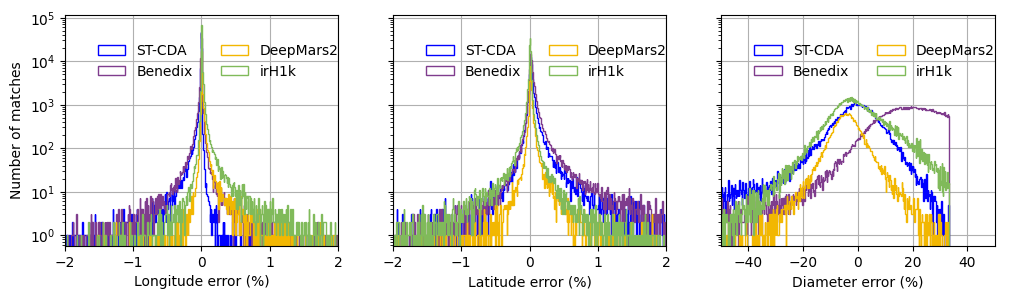

In [ ]:
fig, axs = plt.subplots(1,3,figsize=(12,3), sharey=True)
# B20 i.e., figure 2
ranges = {"Long":np.linspace(-2,2,501),
          "Lat":np.linspace(-2,2,501),
          "Diameter":np.linspace(-50,50,501),
      }

_xlim=(-180,180)
_ylim=(-65,65)
_dlim=(1.5,10)

all_data = {"Benedix": {"Long":longitude_list_benedix_b20,
                        "Lat":latitude_list_benedix_b20,
                        "Diameter":diameter_list_benedix_b20},
            "ST-CDA": {"Long": longitude_list_dt_b20,
                       "Lat": latitude_list_dt_b20,
                       "Diameter":diameter_list_dt_b20},
            "DeepMars2": {"Long": longitude_list_DeepMars2_b20,
                       "Lat": latitude_list_DeepMars2_b20,
                       "Diameter":diameter_list_DeepMars2_b20},
            "irH1k": {"Long": longitude_list_irH1k_b20,
                       "Lat": latitude_list_irH1k_b20,
                       "Diameter":diameter_list_irH1k_b20

            }
            }


for name in plot_names:
    # entry = filter_data(catalogs[name],xlim=xlim,ylim=ylim,dlim=dlim)
    # delta = calc_distance(name,entry,override_method=override_method)
    delta = all_data[name]

    for k,a in zip(ranges.keys(),axs):
        # myname = name.split("/")[2].split("_")[0]
        myname = name
        delta[k].hist(bins=ranges[k],ax=a,color=colors[myname],label=labels.get(myname,myname),histtype='step')

        a.set_yscale('log')
        a.legend(frameon=False, ncol=2, loc=(0.10,0.7))
        kname = labels.get(k,k)
        a.set_xlabel(f"{kname} error (%)")
        a.set_xlim(ranges[k].min(), ranges[k].max())
    axs[0].set_ylabel("Number of matches")

### L19

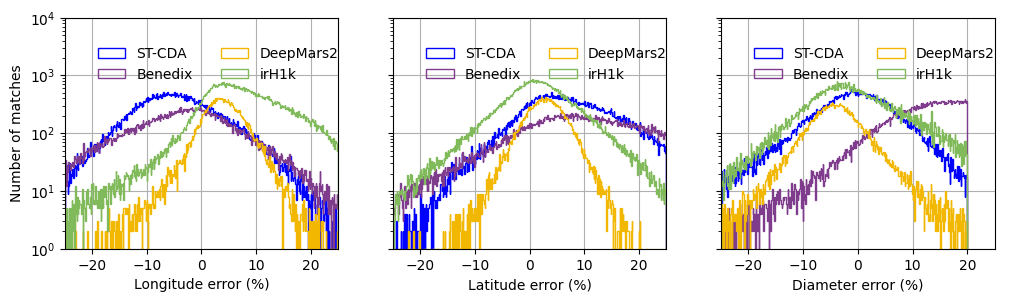

In [ ]:
fig, axs = plt.subplots(1,3,figsize=(12,3), sharey=True)
# L19 i.e., figure 3
ranges = {"Long":np.linspace(-25,25,501),
          "Lat":np.linspace(-25,25,501),
          "Diameter":np.linspace(-25,25,501),
      }

_xlim=(-180,180)
_ylim=(-65,65)
_dlim=(1.5,10)

all_data = {"Benedix": {"Long":longitude_list_benedix_l19,
                        "Lat":latitude_list_benedix_l19,
                        "Diameter":diameter_list_benedix_l19},
            "ST-CDA": {"Long": longitude_list_dt_l19,
                       "Lat": latitude_list_dt_l19,
                       "Diameter":diameter_list_dt_l19},
            "DeepMars2": {"Long": longitude_list_DeepMars2_l19,
                       "Lat": latitude_list_DeepMars2_l19,
                       "Diameter":diameter_list_DeepMars2_l19},
            "irH1k": {"Long": longitude_list_irH1k_l19,
                       "Lat": latitude_list_irH1k_l19,
                       "Diameter":diameter_list_irH1k_l19

            }
            }


for name in plot_names:
    # entry = filter_data(catalogs[name],xlim=xlim,ylim=ylim,dlim=dlim)
    # delta = calc_distance(name,entry,override_method=override_method)
    delta = all_data[name]

    for k,a in zip(ranges.keys(),axs):
        # myname = name.split("/")[2].split("_")[0]
        myname = name
        delta[k].hist(bins=ranges[k],ax=a,color=colors[myname],label=labels.get(myname,myname),histtype='step')

        a.set_yscale('log')
        a.legend(frameon=False, ncol=2, loc=(0.10,0.7))
        kname = labels.get(k,k)
        a.set_xlabel(f"{kname} error (%)")
        a.set_xlim(ranges[k].min(), ranges[k].max())
        a.set_ylim(1,1e4)
    axs[0].set_ylabel("Number of matches")

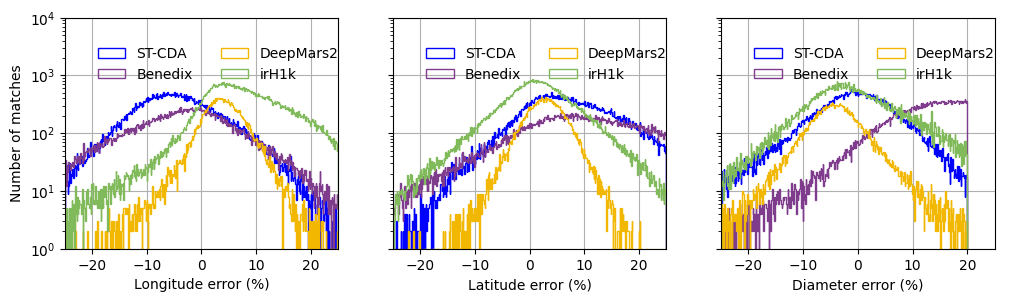

In [ ]:
fig, axs = plt.subplots(1,3,figsize=(12,3), sharey=True)
# L19 i.e., figure 3
ranges = {"Long":np.linspace(-25,25,501),
          "Lat":np.linspace(-25,25,501),
          "Diameter":np.linspace(-25,25,501),
      }

_xlim=(-180,180)
_ylim=(-65,65)
_dlim=(1.5,10)

all_data = {"Benedix": {"Long":longitude_list_benedix_l19,
                        "Lat":latitude_list_benedix_l19,
                        "Diameter":diameter_list_benedix_l19},
            "ST-CDA": {"Long": longitude_list_dt_l19,
                       "Lat": latitude_list_dt_l19,
                       "Diameter":diameter_list_dt_l19},
            "DeepMars2": {"Long": longitude_list_DeepMars2_l19,
                       "Lat": latitude_list_DeepMars2_l19,
                       "Diameter":diameter_list_DeepMars2_l19},
            "irH1k": {"Long": longitude_list_irH1k_l19,
                       "Lat": latitude_list_irH1k_l19,
                       "Diameter":diameter_list_irH1k_l19

            }
            }


for name in plot_names:
    # entry = filter_data(catalogs[name],xlim=xlim,ylim=ylim,dlim=dlim)
    # delta = calc_distance(name,entry,override_method=override_method)
    delta = all_data[name]

    for k,a in zip(ranges.keys(),axs):
        # myname = name.split("/")[2].split("_")[0]
        myname = name
        delta[k].hist(bins=ranges[k],ax=a,color=colors[myname],label=labels.get(myname,myname),histtype='step')

        a.set_yscale('log')
        a.legend(frameon=False, ncol=2, loc=(0.10,0.7))
        kname = labels.get(k,k)
        a.set_xlabel(f"{kname} error (%)")
        a.set_xlim(ranges[k].min(), ranges[k].max())
        a.set_ylim(1,1e4)
    axs[0].set_ylabel("Number of matches")